# 0. Imports packages, modules and functions

## 0.1. Import modules

In [1]:
import pandas                   as pd
import numpy                    as np
import seaborn                  as sns
import matplotlib.pyplot        as plt
import umap.umap_               as ump

from plotly      import express as px

from IPython.display            import Image
from IPython.display            import HTML
from scipy                      import stats
from boruta                     import BorutaPy
from imblearn.combine           import SMOTETomek
from sklearn                    import cluster
from sklearn                    import decomposition
from sklearn.ensemble           import RandomForestRegressor
from sklearn.ensemble           import RandomForestClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.manifold           import TSNE
from sklearn.metrics            import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics            import confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve
from sklearn.metrics            import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics            import confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve
from sklearn.model_selection    import cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.model_selection    import train_test_split
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing      import OneHotEncoder
from pandas_profiling           import ProfileReport
from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer

from xgboost import XGBClassifier

import datetime
import inflection
import math
import pickle
import random
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## 0.2. Helper functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corrected = chi2 - ((k - 1)*(r - 1))/(n - 1)
    k_corrected = k - ((k - 1)**2)/(n - 1)
    r_corrected = r - ((r - 1)**2)/(n - 1)
    
    return np.sqrt((chi2_corrected/n) / (min(k_corrected - 1, r_corrected - 1)))

def get_class_count(df, identification, target_var):
    
    class_count = df.groupby([target_var])[identification].nunique()
    return {key: class_count[key] for key in list(class_count.keys())}

def get_class_proportion(df, identification, target_var):
    
    class_counts = get_class_count(df, identification , target_var)
    return {val[0]: round(100 * val[1]/df.shape[0], 2) for val in class_counts.items()}

def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, cm_df

## 0.3. Loading data

In [3]:
 # load data
df_raw = pd.read_csv( '../data/raw/Ecommerce.csv', encoding = "ISO-8859-1" )

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

## 0.4. Image controls

In [4]:
 def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 15]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1. Data description

In [5]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [6]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns = cols_new
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.2. Data dimensions

In [8]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


The dataset consist of more than 500,000 items purchases with different purchases must refer to the same purchase order and customer, while it has only 8 columns.

## 1.3. Data types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

The types of the invoice number, customer id and invoice date seem to have the wrong type. Customer ID and invoice number should be represented by the int number type, while the invoice date should be represented by a datetime.

## 1.4. Check NA

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replacing NA

In [11]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# Coalescing columns customer_id_x and customer_id_y
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# Droping extra customer_id columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [12]:
df1 = df1.dropna(subset=['description', 'customer_id'])

print('Removed data: {:.2f}%'.format(100*(1 - (df1.shape[0]/df_raw.shape[0]))))

Removed data: 0.27%


In [13]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

The data has many problems with NA purchase orders, that may be represented by some business problem or relevant information, such as reversed logistics to product change or devolution. It can be represented by both the negative quantities and the letters whitin the invoice number. All those data will be removed from the dataset.

## 1.6. Change dtypes

In [14]:
 # invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

Even after the removal of NA values, it was not possible to remove all invoice numbers with a letter in it. So, it was not possible to change the invoice number type. Maybe it could be necessary to create features that properly represents the business problem behind the reason of a letter to appear in it. 

## 1.7. Descriptive statistics

It is intended to solve the clusterization problem with the RFM model, the descriptive statistics will be done again after the creation of the variables necessary to create the model.

In [16]:
num_att = df1.select_dtypes(include=['int64', 'float64'])
cat_att = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical attributes

In [17]:
# Central tendency - mean, median

mean = pd.DataFrame(num_att.apply(np.mean)).T
median = pd.DataFrame(num_att.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis

std_deviation = pd.DataFrame(num_att.apply(np.std)).T
min_value = pd.DataFrame(num_att.apply(min)).T
max_value = pd.DataFrame(num_att.apply(max)).T
range_values = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

desc_stat = pd.concat([min_value, max_value, range_values, mean, median, std_deviation, skew, kurtosis]).T.reset_index()
desc_stat.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
desc_stat

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.603129,3.00,218.007397,-0.281253,120252.449063
1,unit_price,-11062.06,38970.0,50032.06,4.623519,2.08,96.889538,186.257919,58848.017575
2,customer_id,12346.00,22709.0,10363.00,16678.153600,16241.00,2907.570262,0.493600,-0.792496


From the results we can observe values of standard deviation one order higher than the mean and the median, also with negative values. For the unit price, we can see that there are some occurrencies of products with price 0.

### 1.7.2. Categorical attributes

In [18]:
strings1 = len( cat_att.loc[ cat_att['invoice_no'].apply( lambda x: bool(re.search( '[^0-9]+', x ) ) ), 'invoice_no' ].drop_duplicates() )
strings2 = len( cat_att.loc[ cat_att['stock_code'].apply( lambda x: bool(re.search( '[^0-9]+', x ) ) ), 'stock_code' ].drop_duplicates() )
strings3 = len(cat_att.loc[ cat_att['stock_code'].apply( lambda x: bool(re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code' ])

strings = cat_att.loc[ cat_att['stock_code'].apply( lambda x: bool(re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code' ].unique()

total1 = len(cat_att['invoice_no'].drop_duplicates())
total2 = len(cat_att['stock_code'].drop_duplicates())

perc1 = 100 * strings1 / total1
perc2 = 100 * strings2 / total2

In [19]:
print('There are a total of {}/{} ({:,.2f} %)) different invoice numbers with a letter in it, {}/{} ({:,.2f} %) different stock codes with a letter in it and {} appearances of the letters {} as a stock code'.format( strings1, total1, perc1, strings2, total2, perc2, strings3, strings ))

There are a total of 3839/24446 (15.70 %)) different invoice numbers with a letter in it, 1073/3958 (27.11 %) different stock codes with a letter in it and 2754 appearances of the letters ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK'] as a stock code


# 2. Variable filtering

In [20]:
df2 = df1.copy()

All values of clients with a quantity equal or lesser than 0 will be removed from the dataset, since this type of customer will not be elected as a insider anyway. Afterwards, the quantity column will be removed, since its information is contained inside the ticket per product.

In [21]:
# prices higher than 1 cent
df2 = df2.loc[(df1['unit_price'] > 0.01), :]

# customer from a known region
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified' ] ) ]

# stock code different from not explained codes
df2 = df2[~df2['stock_code'].isin( ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS' 'B' 'CRUK'] ) ]

# returned products
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_returns['gross_returns'] = df2_returns['quantity'] * df2_returns['unit_price'] * (- 1)

# positive quantities
df2_purchase = df2.loc[(df2['quantity'] > 0), :]
df2_purchase.loc[:,'gross_purchases'] = df2_purchase.loc[:,'quantity'] * df2_purchase.loc[:,'unit_price']


# 3. Feature engineering

In [82]:
df3 = df2.copy()

## 3.1. Feature creation

The features will be created in order to adjust the clusterization problem with a RFM model solution. For this, the main features within the model will be the monetary, frequency and recency. The monetary consists of the total amount of revenue from a given client, the frequency measures how many different purchases the client has made, while the recency measures the difference between the actual date (highest date within the dataset) and the last purchase date.

In [83]:
 # data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'description', 'quantity',
                    'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates().reset_index(drop=True)

### 3.1.1. Gross purchases and devolutions

In [84]:
# Purchases
df3['purchases'] = df2_purchase['quantity'] * df2_purchase['unit_price']
df3['devolutions'] = df2_returns['quantity'] * df2_returns['unit_price']

# Monetary
df_monetary = df3[['customer_id', 'purchases', 'devolutions']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions
0,17850,5391.21,-102.58
1,13047,3237.54,-158.44
2,12583,7281.38,-94.04
3,13748,948.25,0.00
4,15100,876.00,-240.90
5,15291,4668.30,-71.79
6,14688,5630.87,-523.49
7,17809,5411.91,-784.29
8,15311,60767.90,-1348.56
9,14527,8508.82,-797.44


### 3.1.2. Recency for purchases and devolutions - newest occurence

In [85]:
# Recency - Last day purchase
df_recency_p = df2_purchase[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency_p['recency_p'] = ( df3['invoice_date'].max() - df_recency_p['invoice_date'] ).dt.days
df_recency_p = df_recency_p[['customer_id', 'recency_p']].copy()
df_ref = pd.merge( df_ref, df_recency_p, on='customer_id', how='left' )

# Recency - Last day devolution
df_recency_d = df2_returns[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency_d['recency_d'] = ( df3['invoice_date'].max() - df_recency_d['invoice_date'] ).dt.days
df_recency_d = df_recency_d[['customer_id', 'recency_d']].copy()
df_ref = pd.merge( df_ref, df_recency_d, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions,recency_p,recency_d
0,17850,5391.21,-102.58,372.0,302.0
1,13047,3237.54,-158.44,31.0,31.0
2,12583,7281.38,-94.04,2.0,56.0
3,13748,948.25,0.00,95.0,NaN
4,15100,876.00,-240.90,333.0,330.0
5,15291,4668.30,-71.79,25.0,172.0
6,14688,5630.87,-523.49,7.0,7.0
7,17809,5411.91,-784.29,16.0,16.0
8,15311,60767.90,-1348.56,0.0,0.0
9,14527,8508.82,-797.44,2.0,8.0


### 3.1.3. Quantity of product pruchased or returned

In [86]:
# Frequency - both purchases and returns
df_freq_p = df2_purchase[['customer_id', 'quantity']].drop_duplicates().groupby( 'customer_id' ).sum().reset_index().rename(columns={'quantity':'quantity_p'})
df_ref = pd.merge( df_ref, df_freq_p, on='customer_id', how='left' )

df_freq_d = df2_returns[['customer_id', 'quantity']].drop_duplicates().groupby( 'customer_id' ).sum().reset_index().rename(columns={'quantity':'quantity_d'})
df_ref = pd.merge( df_ref, df_freq_d, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d
0,17850,5391.21,-102.58,372.0,302.0,35.0,-21.0
1,13047,3237.54,-158.44,31.0,31.0,132.0,-6.0
2,12583,7281.38,-94.04,2.0,56.0,1569.0,-50.0
3,13748,948.25,0.00,95.0,NaN,169.0,NaN
4,15100,876.00,-240.90,333.0,330.0,48.0,-22.0
5,15291,4668.30,-71.79,25.0,172.0,508.0,-27.0
6,14688,5630.87,-523.49,7.0,7.0,579.0,-281.0
7,17809,5411.91,-784.29,16.0,16.0,961.0,-41.0
8,15311,60767.90,-1348.56,0.0,0.0,2167.0,-231.0
9,14527,8508.82,-797.44,2.0,8.0,198.0,-3.0


### 3.1.4. Quantity of invoices for purchases and returns

In [87]:
# Frequency - both purchases and returns
df_invoices_p = df2_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename(columns={'invoice_no':'invoices_p'})
df_ref = pd.merge( df_ref, df_invoices_p, on='customer_id', how='left' )

df_invoices_d = df2_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename(columns={'invoice_no':'invoices_d'})
df_ref = pd.merge( df_ref, df_invoices_d, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d,invoices_p,invoices_d
0,17850,5391.21,-102.58,372.0,302.0,35.0,-21.0,34.0,1.0
1,13047,3237.54,-158.44,31.0,31.0,132.0,-6.0,10.0,8.0
2,12583,7281.38,-94.04,2.0,56.0,1569.0,-50.0,15.0,3.0
3,13748,948.25,0.00,95.0,NaN,169.0,NaN,5.0,NaN
4,15100,876.00,-240.90,333.0,330.0,48.0,-22.0,3.0,3.0
5,15291,4668.30,-71.79,25.0,172.0,508.0,-27.0,15.0,5.0
6,14688,5630.87,-523.49,7.0,7.0,579.0,-281.0,21.0,6.0
7,17809,5411.91,-784.29,16.0,16.0,961.0,-41.0,12.0,3.0
8,15311,60767.90,-1348.56,0.0,0.0,2167.0,-231.0,91.0,27.0
9,14527,8508.82,-797.44,2.0,8.0,198.0,-3.0,55.0,31.0


### 3.1.5. Average ticket value

In [88]:
# average ticket - for purchases only
df_avg_ticket = df2_purchase.loc[:,['customer_id', 'gross_purchases']].groupby('customer_id').mean().reset_index().rename(columns={'gross_purchases':'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left' )
df_ref.head(10)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d,invoices_p,invoices_d,avg_ticket
0,17850,5391.21,-102.58,372.0,302.0,35.0,-21.0,34.0,1.0,18.152222
1,13047,3237.54,-158.44,31.0,31.0,132.0,-6.0,10.0,8.0,18.822907
2,12583,7281.38,-94.04,2.0,56.0,1569.0,-50.0,15.0,3.0,29.479271
3,13748,948.25,0.00,95.0,NaN,169.0,NaN,5.0,NaN,33.866071
4,15100,876.00,-240.90,333.0,330.0,48.0,-22.0,3.0,3.0,292.000000
5,15291,4668.30,-71.79,25.0,172.0,508.0,-27.0,15.0,5.0,45.323301
6,14688,5630.87,-523.49,7.0,7.0,579.0,-281.0,21.0,6.0,17.219786
7,17809,5411.91,-784.29,16.0,16.0,961.0,-41.0,12.0,3.0,88.719836
8,15311,60767.90,-1348.56,0.0,0.0,2167.0,-231.0,91.0,27.0,25.543464
9,14527,8508.82,-797.44,2.0,8.0,198.0,-3.0,55.0,31.0,8.753930


### 3.1.6. Average recency days

In [89]:
df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id','invoice_date'], ascending=['True','False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift(-1) # next customer
df_aux['next_next_customer_id'] = df_aux['next_customer_id'].shift(-1) # next customer
df_aux['next_invoice_date'] = df_aux['invoice_date'].shift(-1) # next invoice date

#today =  datetime.datetime.fromtimestamp(df3['invoice_date'].max().to_datetime())
#today_date = datetime.datetime.strptime( today, '%Y-%m-%d')
today_date = df3['invoice_date'].max()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['next_invoice_date'] - x['invoice_date']).days if (x['customer_id'] == x['next_customer_id']) 
                                                                                                    else ( (x['next_invoice_date'] - x['invoice_date']) if (x['customer_id'] == x['next_next_customer_id']) 
                                                                                                                                                        else (today_date - x['invoice_date']).days), axis=1)
df_avg_recency_days = df_aux[['customer_id','avg_recency_days']].groupby('customer_id').mean().reset_index()

# Merging
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')

print(df_aux.head(10))
print(df_ref.head())

        customer_id invoice_date  next_customer_id  next_next_customer_id next_invoice_date  avg_recency_days
61619         12346   2017-01-16           12347.0                12347.0        2016-12-05               325
14938         12347   2016-12-05           12347.0                12347.0        2017-01-24                50
72246         12347   2017-01-24           12347.0                12347.0        2017-04-05                71
148285        12347   2017-04-05           12347.0                12347.0        2017-06-07                63
220572        12347   2017-06-07           12347.0                12347.0        2017-07-31                54
286621        12347   2017-07-31           12347.0                12347.0        2017-10-29                90
428957        12347   2017-10-29           12347.0                12348.0        2017-12-05                37
535004        12347   2017-12-05           12348.0                12348.0        2016-12-14                 2
34083     

### 3.1.7. Basket size and unique products

In [90]:
df_aux = ( df2_purchase.loc[:,['customer_id','invoice_no','quantity']].groupby('customer_id')
                                                                       .agg(n_purchase=('invoice_no', 'nunique'),
                                                                            n_products=('quantity', 'sum'))
                                                                       .reset_index() )

df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge(df_ref, df_aux, how='left', on='customer_id')

df_aux = ( df2_purchase.loc[:,['customer_id','invoice_no','stock_code']].groupby('customer_id')
                                                                       .agg(n_purchase=('invoice_no', 'nunique'),
                                                                            n_products=('stock_code', 'count'))
                                                                       .reset_index() )

df_aux['avg_variety'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge(df_ref, df_aux, how='left', on='customer_id')

### 3.1.8. Frequency - purchases per day

In [91]:
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .agg( max_=('invoice_date', 'max'),
                                                                  min_=('invoice_date', 'min'),
                                                                  buys_=('invoice_no','count'))
                                                            .reset_index()  )
# Calculating the days
df_aux['days_'] = df_aux[['max_','min_']].apply(lambda x: (x['max_'] - x['min_']).days + 1 , axis=1)

# Frequency
df_aux['purchases_pday'] = df_aux[['buys_','days_']].apply(lambda x: x['buys_'] / x['days_'] if (x['days_'] !=0 ) else 0, axis=1)

# Merging
df_ref = pd.merge(df_ref, df_aux[['customer_id','purchases_pday']], on='customer_id', how='left')
df_ref.sample(20)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d,invoices_p,invoices_d,avg_ticket,avg_recency_days,n_purchase_x,n_products_x,avg_basket_size,n_purchase_y,n_products_y,avg_variety,purchases_pday
387,17596,2827.93,0.00,23.0,NaN,1751.0,NaN,7.0,NaN,10.473815,52.571429,7.0,4400.0,628.571429,7.0,270.0,38.571429,0.020231
4146,21244,12.75,0.00,144.0,NaN,1.0,NaN,1.0,NaN,12.750000,144.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000
4175,21280,1.65,0.00,143.0,NaN,1.0,NaN,1.0,NaN,1.650000,143.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000
2349,14077,499.42,0.00,40.0,NaN,143.0,NaN,5.0,NaN,11.890952,54.800000,5.0,268.0,53.600000,5.0,42.0,8.400000,0.021277
2940,13544,291.41,0.00,39.0,NaN,29.0,NaN,2.0,NaN,3.349540,120.000000,2.0,127.0,63.500000,2.0,87.0,43.500000,0.009901
4467,16536,548.97,-9.95,110.0,107.0,98.0,-1.0,1.0,1.0,9.981273,55.000000,1.0,251.0,251.000000,1.0,55.0,55.000000,1.000000
2314,15206,420.30,0.00,10.0,NaN,30.0,NaN,4.0,NaN,46.700000,68.750000,4.0,162.0,40.500000,4.0,9.0,2.250000,0.015038
5076,13212,788.08,-7.50,19.0,9.0,76.0,-1.0,3.0,1.0,5.549859,20.333333,3.0,310.0,103.333333,3.0,142.0,47.333333,0.069767
2925,17278,246.04,0.00,241.0,NaN,77.0,NaN,1.0,NaN,16.402667,241.000000,1.0,179.0,179.000000,1.0,15.0,15.000000,1.000000
483,19107,24.90,0.00,367.0,NaN,1.0,NaN,1.0,NaN,4.980000,367.000000,1.0,5.0,5.000000,1.0,5.0,5.000000,1.000000


In [92]:
df_ref.isna().sum()

customer_id            0
purchases              0
devolutions            0
recency_p            215
recency_d           4201
quantity_p           215
quantity_d          4201
invoices_p           215
invoices_d          4201
avg_ticket           215
avg_recency_days       0
n_purchase_x         215
n_products_x         215
avg_basket_size      215
n_purchase_y         215
n_products_y         215
avg_variety          215
purchases_pday       215
dtype: int64

In [93]:
print( 'Number of rows: {}'.format( df_ref.shape[0] ) )
print( 'Number of cols: {}'.format( df_ref.shape[1] ) )

Number of rows: 5971
Number of cols: 18


## 3.2. Feature engineering

In [94]:
df_ref = df_ref.drop(['n_purchase_x', 'n_purchase_y', 'n_products_x', 'n_products_y'], axis=1)

df_ref['devolutions'] = df_ref['devolutions'].apply(lambda x: (-1*x) if x < 0   else x )

df_ref['quantity_d'] = df_ref['quantity_d'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['recency_d'] = df_ref['recency_d'].apply( lambda x: 365 if math.isnan(x) else x )
df_ref['quantity_d'] = df_ref['quantity_d'].apply( lambda x: 0.00 if math.isnan(x) else x*(-1) )
df_ref['invoices_d'] = df_ref['invoices_d'].apply( lambda x: 0.00 if math.isnan(x) else x )

df_ref['quantity_p'] = df_ref['quantity_p'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['recency_p'] = df_ref['recency_p'].apply( lambda x: 365 if math.isnan(x) else x )
df_ref['quantity_p'] = df_ref['quantity_p'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['invoices_p'] = df_ref['invoices_p'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['avg_ticket'] = df_ref['avg_ticket'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['purchases_pday'] = df_ref['purchases_pday'].apply( lambda x: 0.00 if math.isnan(x) else x )

df_ref['avg_variety'] = df_ref['avg_variety'].apply( lambda x: 0.00 if math.isnan(x) else x )
df_ref['avg_basket_size'] = df_ref['avg_basket_size'].apply( lambda x: 0.00 if math.isnan(x) else x )

df_ref.sample(10)

,customer_id,purchases,devolutions,recency_p,recency_d,quantity_p,quantity_d,invoices_p,invoices_d,avg_ticket,avg_recency_days,avg_basket_size,avg_variety,purchases_pday
2417,12994,974.42,72.20,4.0,107.0,103.0,6.0,3.0,2.0,15.974098,53.600000,153.000000,20.333333,0.011321
2813,20185,2.34,0.00,248.0,365.0,6.0,-0.0,1.0,0.0,2.340000,248.000000,6.000000,1.000000,1.000000
3380,14489,463.38,0.00,207.0,365.0,67.0,-0.0,1.0,0.0,15.446000,207.000000,299.000000,30.000000,1.000000
864,16145,3799.49,57.51,8.0,91.0,341.0,40.0,11.0,7.0,16.962009,19.944444,283.909091,20.363636,0.031250
3782,20951,5.88,0.00,176.0,365.0,8.0,-0.0,1.0,0.0,1.176000,176.000000,14.000000,5.000000,1.000000
755,14413,122.70,0.00,362.0,365.0,24.0,-0.0,1.0,0.0,5.334783,362.000000,68.000000,23.000000,1.000000
5062,13755,2161.35,6.67,3.0,25.0,237.0,23.0,9.0,1.0,6.319737,7.875000,140.444444,38.000000,0.147541
3396,20656,1957.17,0.00,206.0,365.0,299.0,-0.0,1.0,0.0,32.619500,206.000000,416.000000,60.000000,1.000000
3985,21114,460.66,0.00,158.0,365.0,50.0,-0.0,1.0,0.0,12.796111,158.000000,93.000000,36.000000,1.000000
3805,12450,197.88,0.00,156.0,365.0,92.0,-0.0,2.0,0.0,24.735000,86.500000,64.000000,4.000000,0.111111


In [95]:
df_ref['gross_revenue'] = (df_ref['purchases'] - df_ref['devolutions'])
df_ref['relative_revenue'] = (df_ref['purchases'] - df_ref['devolutions'])
df_ref['relative_quantity'] = (df_ref['quantity_p'] - df_ref['quantity_d'])
df_ref['relative_invoices'] = (df_ref['invoices_p'] - df_ref['invoices_d'])
df_ref = df_ref.drop(columns=['purchases','devolutions','invoices_p','invoices_d','recency_d'], axis=1)

In [96]:
df_ref.isna().sum()

customer_id          0
recency_p            0
quantity_p           0
quantity_d           0
avg_ticket           0
avg_recency_days     0
avg_basket_size      0
avg_variety          0
purchases_pday       0
gross_revenue        0
relative_revenue     0
relative_quantity    0
relative_invoices    0
dtype: int64

There were a problem whith clients that did not have made any purchase in the analyzed period or did not have done any devolution. For those clients, recency was considered as 365 days or 1 year and the frequency of purchase or devolution was considered 0.

## 3.3. RFM model descriptive statistics

In [97]:
# Central tendency - mean, median

mean = pd.DataFrame(df_ref.apply(np.mean)).T
median = pd.DataFrame(df_ref.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis

std_deviation = pd.DataFrame(df_ref.apply(np.std)).T
min_value = pd.DataFrame(df_ref.apply(min)).T
max_value = pd.DataFrame(df_ref.apply(max)).T
range_values = pd.DataFrame(df_ref.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(df_ref.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(df_ref.apply(lambda x: x.kurtosis())).T

desc_stat = pd.concat([min_value, max_value, range_values, mean, median, std_deviation, skew, kurtosis]).T.reset_index()
desc_stat.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
desc_stat

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,customer_id,12346.00,22709.00,10363.00,16765.631887,16392.000000,2882.295644,0.370682,-0.958112
1,recency_p,0.00,373.00,373.00,126.001507,77.000000,118.720949,0.748847,-0.810383
2,quantity_p,0.00,80996.00,80996.00,254.910735,91.000000,1701.348536,35.097843,1502.456269
3,quantity_d,-0.00,80995.00,80995.00,40.920951,0.000000,1435.725633,53.230140,2885.966697
4,avg_ticket,0.00,77183.60,77183.60,60.594494,15.724600,1274.186238,51.961085,2881.449309
5,avg_recency_days,0.00,373.00,373.00,120.876580,80.000000,102.902782,0.968838,-0.216140
6,avg_basket_size,0.00,74215.00,74215.00,254.165206,142.666667,1169.972880,49.857338,2915.667275
7,avg_variety,0.00,1114.00,1114.00,38.207986,17.000000,75.824553,5.086637,33.552994
8,purchases_pday,0.00,17.00,17.00,0.531211,0.666667,0.550668,4.713846,132.912632
9,gross_revenue,-17836.46,279489.02,297325.48,1635.209799,589.150000,7205.053429,23.795967,757.345168


A first glimpse at the statistical analysis shows that all variables from the RFM model (gross revenue, recency days and number of invoices) shows a high skewed data with maximum values very distant from both the mean and median values. The skewness and the kurtosis can be seen at the distribution graphics of each variable. Also, there are customers with zero or less quantity of products and an non-null value of revenue, this makes the ticket per product go to extremely high values, increasing the outliers for this feature.

# 4. Exploratory data analysis

In [98]:
df4 = df_ref.copy()

In [99]:
# filter to analyze only valid customers
# returned products
df4 = df4.loc[df4['customer_id'] <19000, :]

## 4.1. Univariate analysis

- Relevant metrics
    - Dispersion metrics: we need features that have a high variability, so the odds to create separate and contrated clusters increases;
    - Descriptive statistics: features with higher range or difference between Q1 and Q3, when combined with other feature with similar characteristics increases the probability of separated clusters;
    - Min, Max, Range
    - Standard deviation and variance
    - Variance coefficient

In [170]:
profile = ProfileReport(df4)
profile.to_file('../reports/univariate_output.html')

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [111]:
df4.dtypes

customer_id            int64
recency_p            float64
quantity_p           float64
quantity_d           float64
avg_ticket           float64
avg_recency_days     float64
avg_basket_size      float64
avg_variety          float64
purchases_pday       float64
gross_revenue        float64
relative_revenue     float64
relative_quantity    float64
relative_invoices    float64
dtype: object

### 4.1.1. Looking for outliers

- Features for attention
    - quantity_p for values above 20k
    - quantity_d for values above 4k
    - avg_ticket for values above 4k
    - avg_basket_size for values above 4k
    - purchases_pday for value 17
    - gross_revenue for above 70k
- Features with high correlation
    - recency_p w/ avg_recency_days
    - quantity_p w/ quantity_d
    - quantity_p w/ avg_basket_size
    - quantity_p w/ gross_revenue
    - quantity_d w/ relative variables (all)
    - relative variables are highly correlated between themselves

In [112]:
# looking for outliers to quantity of items purchased
df4[df4['quantity_p'] > 20000].head(10)

,customer_id,recency_p,quantity_p,quantity_d,avg_ticket,avg_recency_days,avg_basket_size,avg_variety,purchases_pday,gross_revenue,relative_revenue,relative_quantity,relative_invoices
434,17450,8.0,38639.0,955.0,577.302047,11.121212,1521.586957,7.326087,0.127778,187482.17,187482.17,37684.0,37.0
1728,16333,7.0,21352.0,-0.0,591.706667,23.769231,1462.909091,2.045455,0.072607,26626.80,26626.80,21352.0,22.0


In [113]:
# looking for outliers to quantity of items returned
df4[df4['quantity_d'] > 4000].head(10)

,customer_id,recency_p,quantity_p,quantity_d,avg_ticket,avg_recency_days,avg_basket_size,avg_variety,purchases_pday,gross_revenue,relative_revenue,relative_quantity,relative_invoices
13,16029,38.0,10828.0,4873.0,334.813388,8.288889,638.222222,3.841270,0.187500,50992.61,50992.61,5955.0,50.0
161,15838,11.0,6474.0,9361.0,201.455569,21.882353,966.736842,8.789474,0.053221,33350.76,33350.76,-2887.0,17.0
984,12931,21.0,16288.0,4027.0,512.877561,23.800000,1866.933333,5.466667,0.044510,33462.81,33462.81,12261.0,10.0


It seems that customers 12346 and 16446 had some problem with the data quality in database, since they have bought a high number of items and returned them. They will be removed from the dataset in order to increase the model result. Other customers with a high number of returns also had a high number of purchases, which seems reasonable.

In [114]:
# looking for outliers to the average ticket of purchases
df4[df4['avg_ticket'] > 3000].head(10)

,customer_id,recency_p,quantity_p,quantity_d,avg_ticket,avg_recency_days,avg_basket_size,avg_variety,purchases_pday,gross_revenue,relative_revenue,relative_quantity,relative_invoices
3536,13135,196.0,4300.0,-0.0,3096.0,196.0,4300.0,1.0,1.0,3096.0,3096.0,4300.0,1.0
5951,15195,2.0,1404.0,-0.0,3861.0,2.0,1404.0,1.0,1.0,3861.0,3861.0,1404.0,1.0


Again, clients 12346 and 16446 shows as an outliers to the average ticket, due to the high amount of items purchases, however with no gross revenue. At this point, it seems that customers 15098 also had some problem, since it has a liquid purchased quantity of 0, however with some gross revenue (purchases higher than returns), this customer will also be removed from the dataset. Also customer 15749 have the same behavior as 15098 and will be removed.

In [115]:
# looking for outliers to the average basket size
df4[df4['avg_basket_size'] > 3000].head(10)

,customer_id,recency_p,quantity_p,quantity_d,avg_ticket,avg_recency_days,avg_basket_size,avg_variety,purchases_pday,gross_revenue,relative_revenue,relative_quantity,relative_invoices
203,16754,372.0,4280.0,-0.0,1001.200000,372.000000,4280.00000,2.0,1.000000,2002.40,2002.40,4280.0,1.0
1168,12415,24.0,9932.0,369.0,174.950322,18.722222,3684.47619,34.0,0.066879,123725.45,123725.45,9563.0,16.0
3536,13135,196.0,4300.0,-0.0,3096.000000,196.000000,4300.00000,1.0,1.000000,3096.00,3096.00,4300.0,1.0
4440,12688,113.0,610.0,-0.0,28.501813,113.000000,3028.00000,171.0,1.000000,4873.81,4873.81,610.0,1.0
4684,18251,87.0,3528.0,-0.0,269.670000,87.000000,7824.00000,16.0,1.000000,4314.72,4314.72,3528.0,1.0


In [116]:
# looking for outliers to the average basket size
df4[df4['purchases_pday'] == 17].head(10)

,customer_id,recency_p,quantity_p,quantity_d,avg_ticket,avg_recency_days,avg_basket_size,avg_variety,purchases_pday,gross_revenue,relative_revenue,relative_quantity,relative_invoices
0,17850,372.0,35.0,21.0,18.152222,124.333333,50.970588,8.735294,17.0,5288.63,5288.63,14.0,33.0


In [117]:
# looking for outliers to the average ticket of purchases
df4[df4['gross_revenue'] > 50000].head(20)

,customer_id,recency_p,quantity_p,quantity_d,avg_ticket,avg_recency_days,avg_basket_size,avg_variety,purchases_pday,gross_revenue,relative_revenue,relative_quantity,relative_invoices
8,15311,0.0,2167.0,231.0,25.543464,4.098901,419.714286,26.142857,0.243316,59419.34,59419.34,1936.0,64.0
13,16029,38.0,10828.0,4873.0,334.813388,8.288889,638.222222,3.841270,0.187500,50992.61,50992.61,5955.0,50.0
16,17511,2.0,4375.0,125.0,94.561142,11.303030,2082.225806,31.064516,0.083333,88125.38,88125.38,4250.0,16.0
37,13694,3.0,13369.0,500.0,114.506373,9.097561,1266.240000,11.360000,0.134771,62653.10,62653.10,12869.0,40.0
67,14911,1.0,4247.0,1608.0,25.343623,2.554795,399.328358,28.233831,0.538874,132572.62,132572.62,2639.0,154.0
173,15061,3.0,6506.0,186.0,135.320447,11.272727,602.500000,8.395833,0.129730,54228.74,54228.74,6320.0,41.0
192,14156,9.0,9208.0,658.0,83.842593,7.294118,1052.454545,25.454545,0.151515,113384.14,113384.14,8550.0,44.0
251,17949,1.0,17376.0,2399.0,835.864000,11.967742,678.800000,1.555556,0.121294,52750.84,52750.84,14977.0,38.0
267,15769,7.0,7846.0,1202.0,432.713231,15.458333,1141.230769,5.000000,0.071233,51823.72,51823.72,6644.0,23.0
280,13089,2.0,1815.0,144.0,32.357442,4.445783,320.309278,18.742268,0.263587,57385.88,57385.88,1671.0,76.0


All clients with gross revenue higher than 50000 seems to behave similarly, with small values for recency of purchases and high values for relative revenue and relative invoices (where 1 means that the customer has only purchases and -1 meaning that the customer only returns). At this point, only 4 customers will be considered as outliers and removed from the dataset: 12346,15098,15749,16446.

In [118]:
customers_outliers = [12346,15098,15749,16446]
df4 = df4[~df4['customer_id'].isin(customers_outliers)]

### 4.2. Bivariate analysis

In [119]:
cols = ['customer_id']
df_bivariate = df4.drop(cols, axis=1)

<Figure size 1800x864 with 0 Axes>

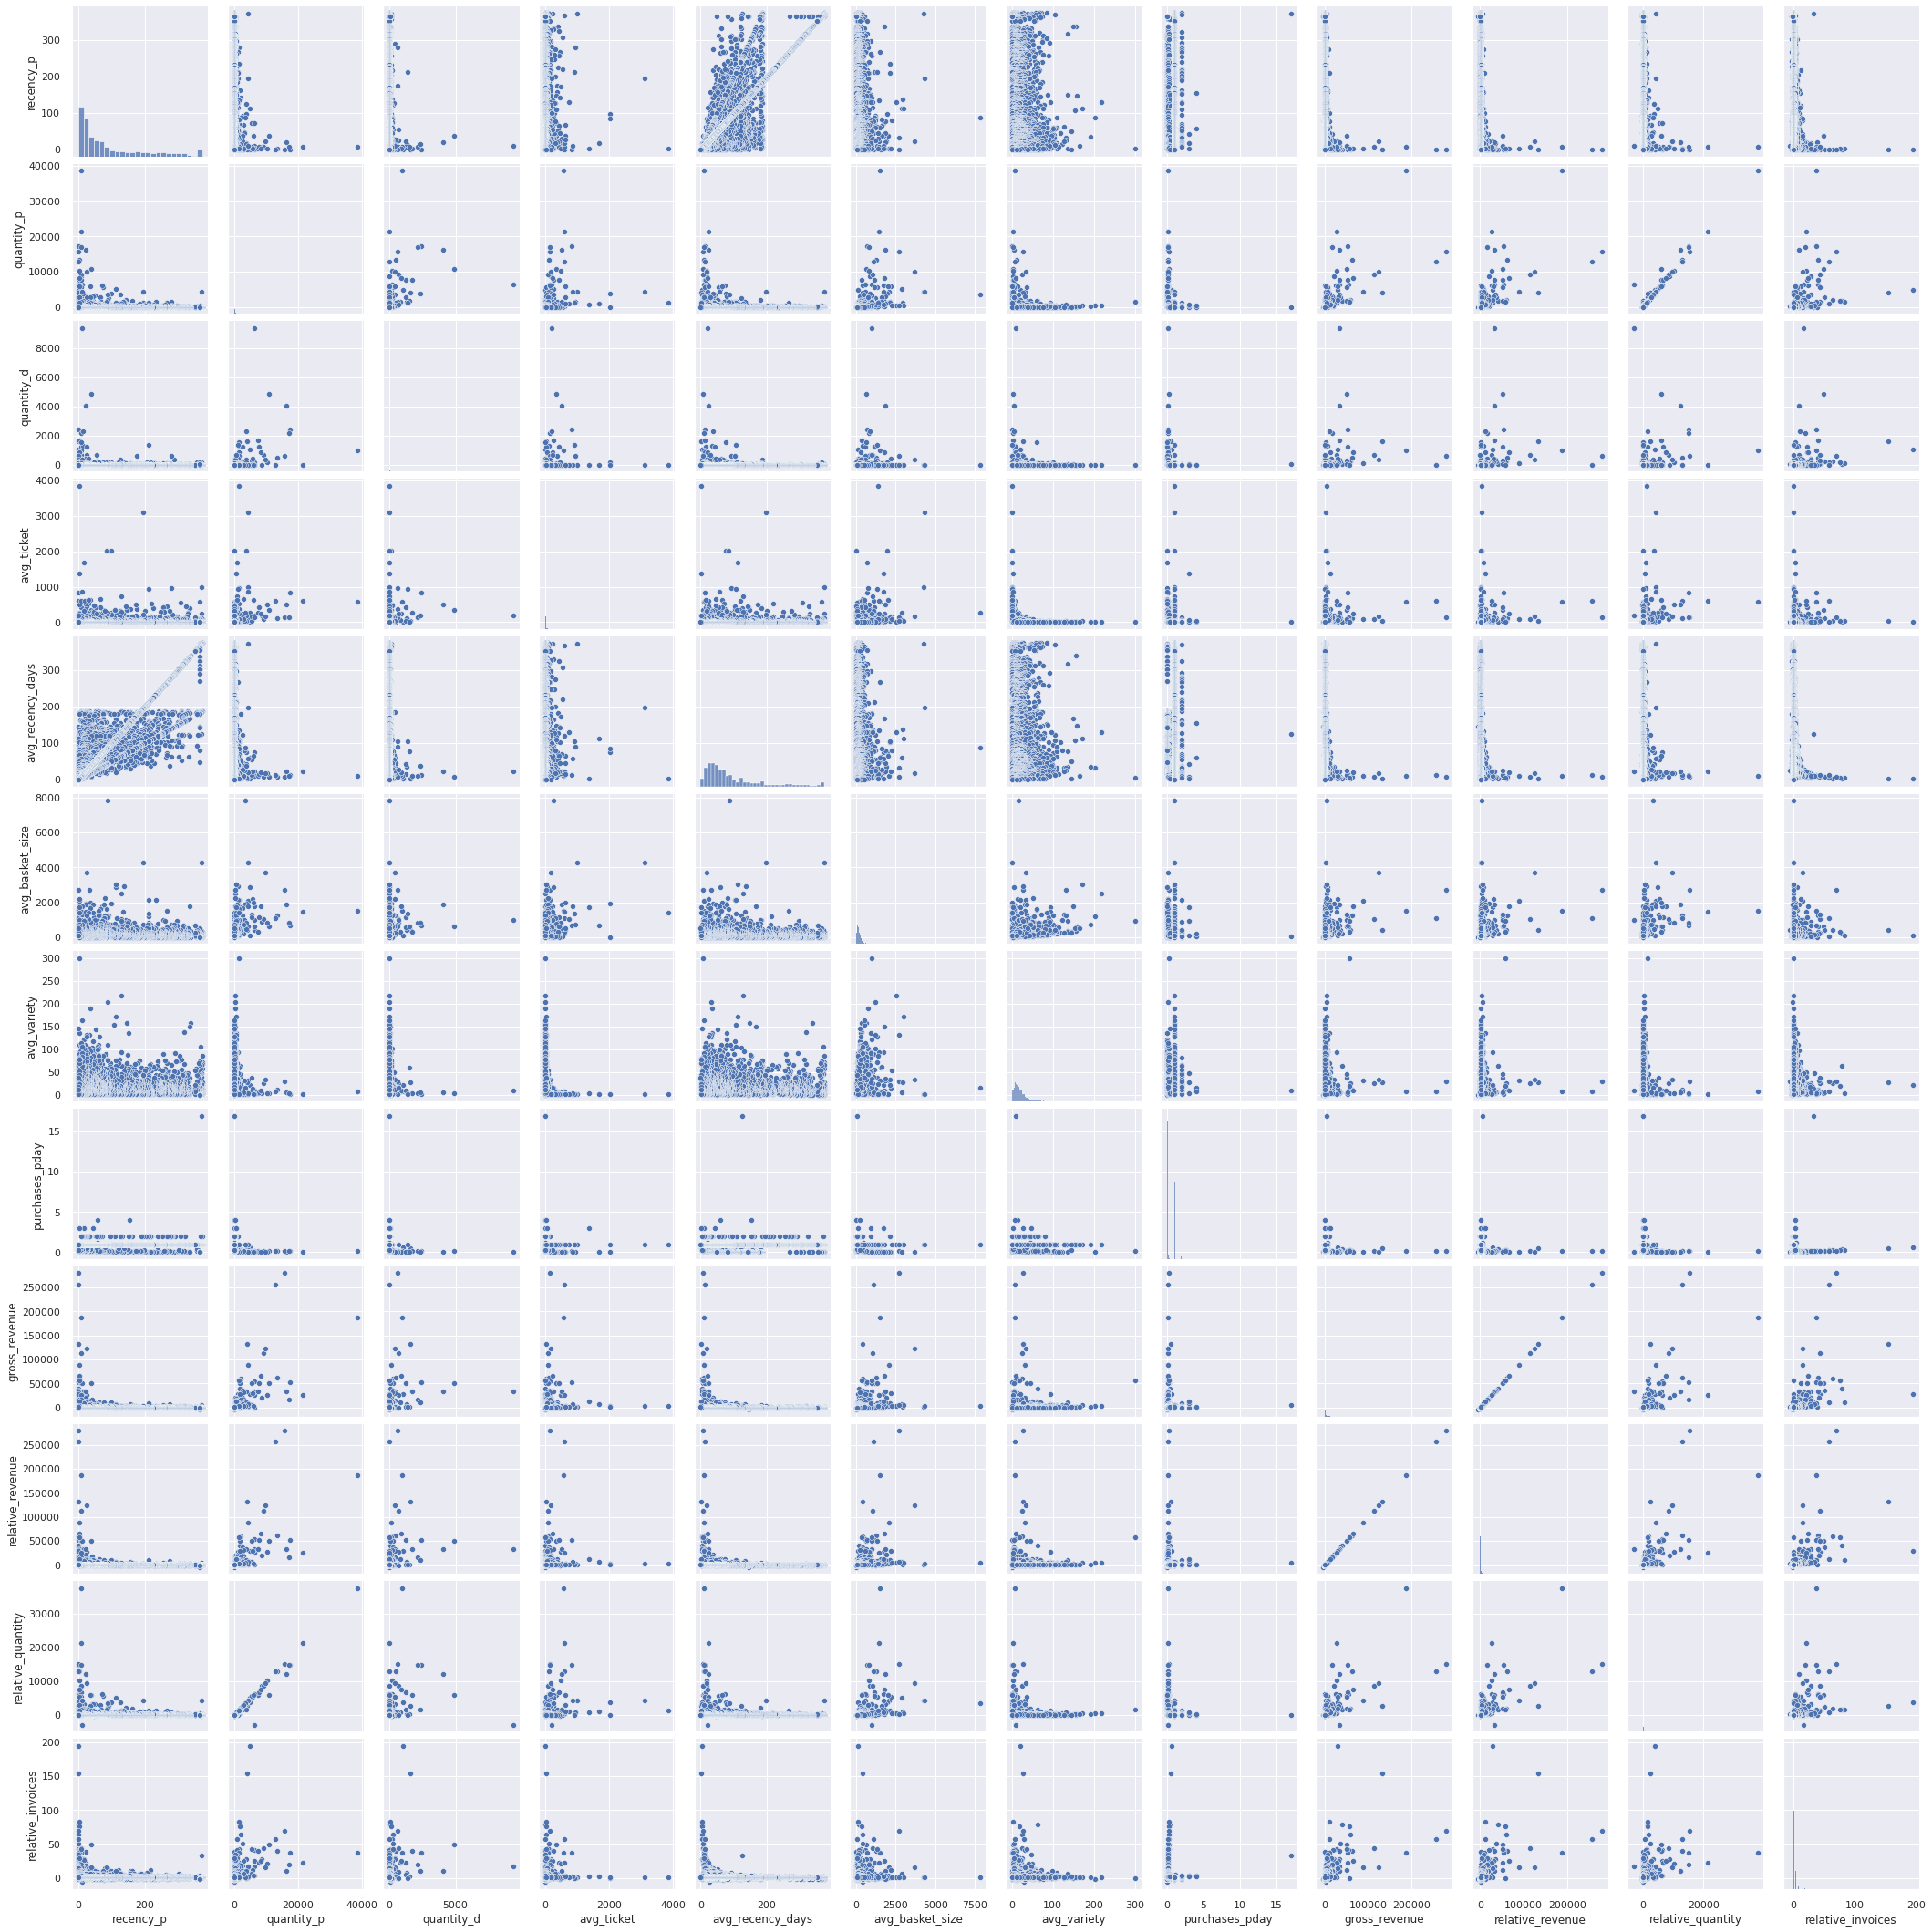

In [120]:
plt.figure(figsize=(25,12))
sns.pairplot(df_bivariate)


In [122]:
df4.head()

,customer_id,recency_p,quantity_p,quantity_d,avg_ticket,avg_recency_days,avg_basket_size,avg_variety,purchases_pday,gross_revenue,relative_revenue,relative_quantity,relative_invoices
0,17850,372.0,35.0,21.0,18.152222,124.333333,50.970588,8.735294,17.000000,5288.63,5288.63,14.0,33.0
1,13047,31.0,132.0,6.0,18.822907,26.642857,139.100000,17.200000,0.029155,3079.10,3079.10,126.0,2.0
2,12583,2.0,1569.0,50.0,29.479271,20.722222,337.333333,16.466667,0.040323,7187.34,7187.34,1519.0,12.0
3,13748,95.0,169.0,-0.0,33.866071,93.250000,87.800000,5.600000,0.017921,948.25,948.25,169.0,5.0
4,15100,333.0,48.0,22.0,292.000000,62.166667,26.666667,1.000000,0.073171,635.10,635.10,26.0,0.0


## 4.3. Data space analysis

In [127]:
data_space = df4.copy()
data_space = data_space.drop(columns=['customer_id','purchases_pday','quantity_p','quantity_d','relative_revenue'], axis=1)

rs = RobustScaler()
#rs = StandardScaler()

#data_space['purchases'] = rs.fit_transform( data_space[['purchases']].values )
#data_space['devolutions'] = rs.fit_transform( data_space[['devolutions']].values )
#data_space['purc_dev'] = rs.fit_transform( data_space[['purc_dev']].values )
data_space['recency_p'] = rs.fit_transform( data_space[['recency_p']].values )
#data_space['recency_d'] = rs.fit_transform( data_space[['recency_d']].values )
#data_space['quantity_p'] = rs.fit_transform( data_space[['quantity_p']].values )
#data_space['quantity_d'] = rs.fit_transform( data_space[['quantity_d']].values )
#data_space['invoices_p'] = rs.fit_transform( data_space[['invoices_p']].values )
#data_space['invoices_d'] = rs.fit_transform( data_space[['invoices_d']].values )

data_space['gross_revenue'] = rs.fit_transform( data_space[['gross_revenue']].values )
data_space['avg_ticket'] = rs.fit_transform( data_space[['avg_ticket']].values )
data_space['avg_recency_days'] = rs.fit_transform( data_space[['avg_recency_days']].values )
data_space['avg_basket_size'] = rs.fit_transform( data_space[['avg_basket_size']].values )
data_space['avg_variety'] = rs.fit_transform( data_space[['avg_variety']].values )
data_space['relative_quantity'] = rs.fit_transform( data_space[['relative_quantity']].values )
data_space['relative_invoices'] = rs.fit_transform( data_space[['relative_invoices']].values )
#data_space['purchases_pday'] = rs.fit_transform( data_space[['purchases_pday']].values )

In [128]:
data_space.head()

,recency_p,avg_ticket,avg_recency_days,avg_basket_size,avg_variety,gross_revenue,relative_quantity,relative_invoices
0,2.469231,0.037959,0.689499,-0.610965,-0.437896,3.517857,-0.592593,10.333333
1,-0.153846,0.090551,-0.419570,-0.118622,0.012354,1.842711,0.098765,0.000000
2,-0.376923,0.926182,-0.486787,0.988827,-0.026653,4.957356,8.697531,3.333333
3,0.338462,1.270178,0.336613,-0.405214,-0.604667,0.227216,0.364198,1.000000
4,2.169231,21.512037,-0.016272,-0.746741,-0.849348,-0.010197,-0.518519,-0.666667


### 4.3.1. PCA - 

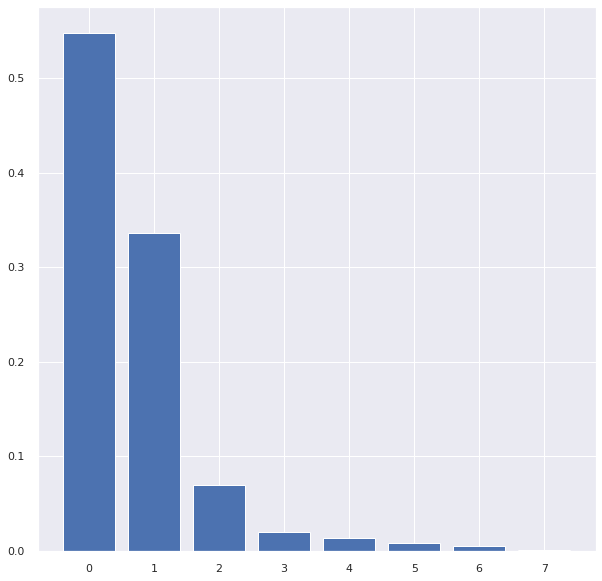

In [129]:
X_PCA = data_space.copy()
pca = decomposition.PCA(n_components=X_PCA.shape[1])

principal_component = pca.fit_transform(X_PCA)

features = range(pca.n_components_)

plt.figure(figsize=(10,10))
plt.bar(features, pca.explained_variance_ratio_)
plt.show()

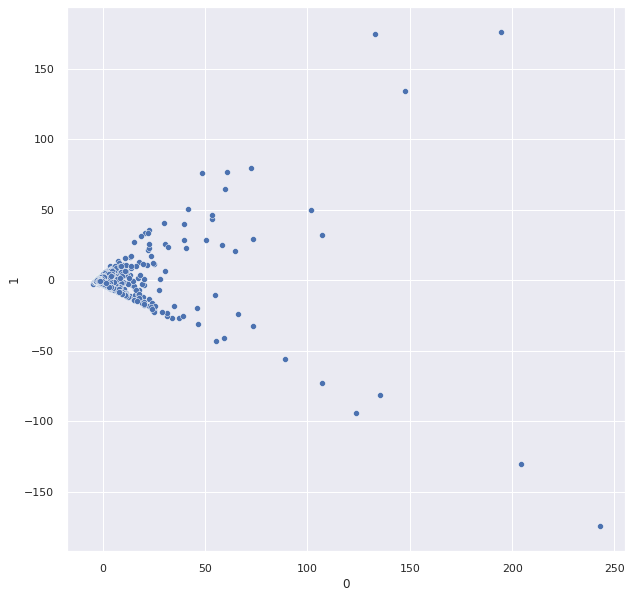

In [130]:
df_pca = pd.DataFrame(principal_component)

plt.figure(figsize=(10,10))
sns.scatterplot(x=0, y=1, data=df_pca)
plt.show()

### 4.3.2. UMAP

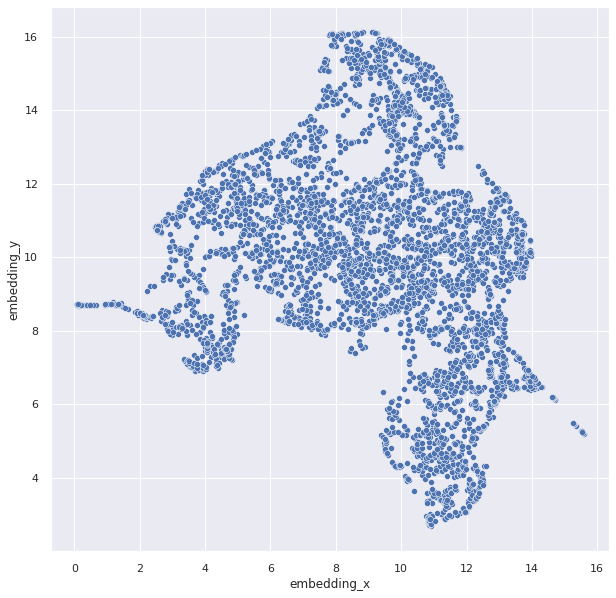

In [131]:
X_UMAP = data_space.copy()
reducer = ump.UMAP( random_state=42)
embedding = reducer.fit_transform(X_UMAP)

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

plt.figure(figsize=(10,10))
sns.scatterplot(x='embedding_x',y='embedding_y', data=df_pca)
plt.show()

In [132]:
df_pca.head()

,0,1,2,3,4,5,6,7,embedding_x,embedding_y
0,-0.009555,2.836535,-4.316107,8.253914,0.449485,4.039858,0.093869,1.535058,4.044032,12.402117
1,-0.975622,0.786990,-1.011452,-0.302248,-0.284870,-1.124969,0.213744,0.076065,7.833179,11.187575
2,5.110515,6.891621,2.792261,2.216699,0.598805,-0.225575,0.295822,-0.042119,3.813621,10.925199
3,-0.501388,-0.698896,-0.058761,0.935810,-0.784246,-0.045137,0.447485,0.001124,8.769810,11.096004
4,14.956861,-13.601882,-2.281528,-0.241303,-2.217709,-0.157348,-0.218511,1.649515,1.260714,8.707685


### 4.3.3. t-SNE

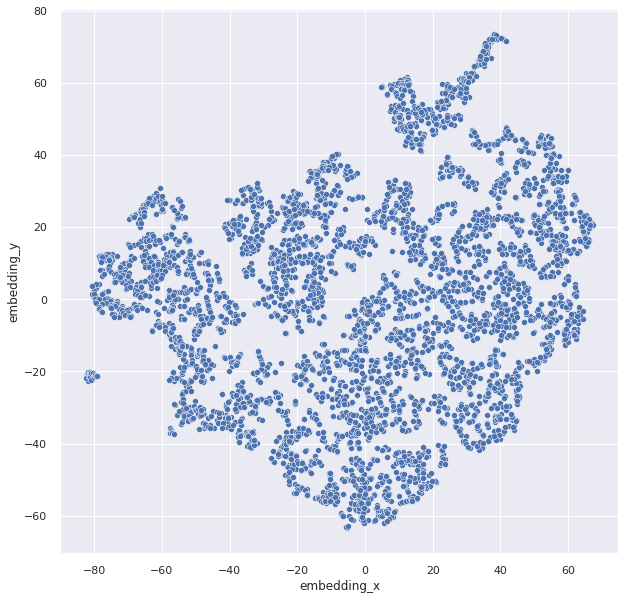

In [133]:
X_TSNE = data_space.copy()
reducer = TSNE( random_state=42)
embedding = reducer.fit_transform(X_TSNE)

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

plt.figure(figsize=(10,10))
sns.scatterplot(x='embedding_x',y='embedding_y', data=df_pca)
plt.show()

### 4.3.4. Tree-based embedding

In [176]:
# training dataset
x_trees = data_space.drop(columns=['gross_revenue'], axis=1)
y_trees = data_space['gross_revenue']

#model definition
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(x_trees, y_trees)

#Leaves
df_leaf = pd.DataFrame(rf_model.apply(x_trees))

#Leaves dataFrame
df_leaf.shape

(4362, 100)

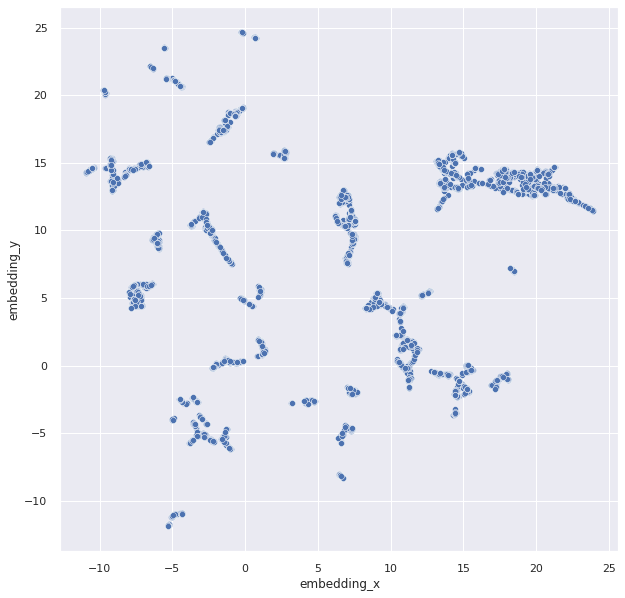

In [177]:
reducer = ump.UMAP( random_state=42)
embedding = reducer.fit_transform(df_leaf)

df_leaf['embedding_x'] = embedding[:,0]
df_leaf['embedding_y'] = embedding[:,1]

plt.figure(figsize=(10,10))
sns.scatterplot(x='embedding_x',y='embedding_y', data=df_leaf)
plt.show()

In [178]:
df_leaf.loc[:,'customer_id'] = df4.loc[:,'customer_id']

# 5. Data preparation

## 5.1. Data rescaling

In [144]:
df_rescaled = df4.copy()
#df_rescaled = data_space.copy()

In [145]:
rs = RobustScaler()
#rs = StandardScaler()

#df_rescaled['purchases'] = rs.fit_transform( df_rescaled[['purchases']].values )
#df_rescaled['devolutions'] = rs.fit_transform( df_rescaled[['devolutions']].values )
#df_rescaled['purc_dev'] = rs.fit_transform( df_rescaled[['purc_dev']].values )
df_rescaled['recency_p'] = rs.fit_transform( df_rescaled[['recency_p']].values )
#df_rescaled['recency_d'] = rs.fit_transform( df_rescaled[['recency_d']].values )
df_rescaled['quantity_p'] = rs.fit_transform( df_rescaled[['quantity_p']].values )
df_rescaled['quantity_d'] = rs.fit_transform( df_rescaled[['quantity_d']].values )

df_rescaled['gross_revenue'] = rs.fit_transform( df_rescaled[['gross_revenue']].values )
df_rescaled['avg_ticket'] = rs.fit_transform( df_rescaled[['avg_ticket']].values )
df_rescaled['avg_recency_days'] = rs.fit_transform( df_rescaled[['avg_recency_days']].values )
df_rescaled['avg_basket_size'] = rs.fit_transform( df_rescaled[['avg_basket_size']].values )
df_rescaled['avg_variety'] = rs.fit_transform( df_rescaled[['avg_variety']].values )
#df_rescaled['invoices_p'] = rs.fit_transform( df_rescaled[['invoices_p']].values )
df_rescaled['purchases_pday'] = rs.fit_transform( df_rescaled[['purchases_pday']].values )
df_rescaled['relative_quantity'] = rs.fit_transform( df_rescaled[['relative_quantity']].values )
df_rescaled['relative_invoices'] = rs.fit_transform( df_rescaled[['relative_invoices']].values )

In [146]:
df_rescaled.head()

,customer_id,recency_p,quantity_p,quantity_d,avg_ticket,avg_recency_days,avg_basket_size,avg_variety,purchases_pday,gross_revenue,relative_revenue,relative_quantity,relative_invoices
0,17850,2.469231,-0.460432,7.000000,0.037959,0.689499,-0.610965,-0.437896,17.299424,3.517857,5288.63,-0.592593,10.333333
1,13047,-0.153846,0.097842,2.000000,0.090551,-0.419570,-0.118622,0.012354,-0.015908,1.842711,3079.10,0.098765,0.000000
2,12583,-0.376923,8.368345,16.666667,0.926182,-0.486787,0.988827,-0.026653,-0.004513,4.957356,7187.34,8.697531,3.333333
3,13748,0.338462,0.310791,-0.000000,1.270178,0.336613,-0.405214,-0.604667,-0.027369,0.227216,948.25,0.364198,1.000000
4,15100,2.169231,-0.385612,7.333333,21.512037,-0.016272,-0.746741,-0.849348,0.029002,-0.010197,635.10,-0.518519,-0.666667


# 6. Feature selection

In [149]:
df6 = df_rescaled.copy()
#df6 = df_leaf.copy()

In [150]:
df6 = df6.drop(columns=['purchases_pday','quantity_p','quantity_d','relative_revenue'],axis=0)

# 7. Hyperparameter fine tuning

There are 3 types of major problems within data problems to solve with machine learning algorithms: regression, classification and clusterization. The first two problems, regression and classification, there is a necessity to split the dataset between training and testing and there is a target variable to analyze the accuracy and precision of the model, while the clusterization problems does not have the need in dataset spliting. Because of that, there is a necessity to first determine the number of clusters which the dataset will be split, before training and finding the model.

In [179]:
#df7 = df6.copy()
df7 = df_leaf.drop(columns=['embedding_x', 'embedding_y'], axis=0)
df7.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,customer_id
0,5382,5396,5250,5330,5019,5415,5330,5355,5101,5198,5274,5324,5243,5241,5234,5070,5143,5249,5177,5311,5456,5269,5372,5343,5030,5309,5191,5303,5306,5229,5112,5498,5221,5246,5259,5395,5350,5397,5283,5306,5196,5313,5183,5129,5150,5269,4996,5346,5297,5440,5428,5375,5186,5260,5279,5337,4591,5264,5353,5158,5427,5255,5244,5420,5261,5302,5241,5270,5231,5312,5281,5338,5223,5229,5371,5308,5136,5347,5360,5299,5214,5359,5202,5334,4992,5246,5276,5387,5136,5186,5293,5366,5116,5288,5101,5352,5276,5051,5357,5389,17850.0
1,1916,3214,1808,2288,3980,2177,1656,1812,2022,2095,1922,1890,2357,2773,1971,1704,1987,1945,3533,1902,1860,1791,1758,1862,3552,2114,1878,1864,2473,2137,1828,2642,1916,1728,1867,2468,2968,2070,1834,1952,2077,3115,1858,2020,1614,2165,1920,1910,1853,2923,1994,2096,1742,1818,2276,2574,3367,1935,2797,1835,1892,2060,2706,2029,2457,2160,2726,3630,2088,1948,1941,1923,1821,3029,3104,3834,2138,2928,1812,3287,1882,2017,1671,1914,1873,1945,1893,3262,1923,1938,1562,2741,1783,1756,1820,2268,2656,1960,2062,2095,13047.0
2,5326,5444,5410,5476,5423,5546,5280,5307,4926,5447,5450,5199,5399,5425,5364,5369,5215,5384,5412,5421,5284,5347,5382,5409,5364,5402,5418,5480,5232,5384,5261,5537,5406,5393,5397,5539,5450,5493,5169,5425,5367,5184,5056,5402,4933,5317,5398,5268,5452,5367,5349,5420,5413,5431,5348,5271,5394,5407,5292,5347,5252,5429,5392,5256,5476,5361,5359,5084,5027,5422,5182,5065,5324,5375,4940,5444,5339,5268,5475,5436,5487,5312,5470,5423,4796,5224,5358,5275,5314,5365,5407,5214,4911,5387,5357,5416,5332,4905,5456,5214,12583.0
3,3228,4028,3496,3682,3328,4150,4078,3367,3498,4033,4727,3442,4185,3770,3273,4487,3403,3527,3884,3413,4232,3835,4832,4446,3881,3710,3372,4531,4614,3847,3317,3687,3330,4702,3297,3717,3563,3830,4118,3979,3310,4240,4187,4244,2967,3766,4064,3385,4696,3656,3184,3597,4054,3992,4125,3906,4243,3399,3397,4387,4369,3452,3540,3185,4495,3661,3474,4012,3308,3101,3633,3588,3630,4462,4150,4543,3338,3641,3177,3783,3580,3693,4441,3406,3767,3284,3674,3902,3222,3273,4259,4103,4178,3917,4426,3945,4786,3121,3733,3939,13748.0
4,383,410,350,212,432,585,392,394,578,641,534,557,330,393,247,171,426,261,527,200,409,237,440,570,530,554,305,518,531,199,1134,161,586,849,266,219,715,648,202,520,575,536,502,496,1041,554,583,577,584,354,612,696,374,206,703,358,410,482,511,569,299,683,504,488,784,870,205,341,601,336,150,390,518,355,569,595,605,751,306,218,304,599,209,284,457,400,207,358,218,566,180,577,1103,320,350,214,588,392,634,226,15100.0


In [180]:
#tree_cols_to_drop = []
#for i in range( 0, (df7.shape[1]-2),1 ):
#    tree_cols_to_drop.append(i)
#    i = i + 1


#X = df7.drop(columns=tree_cols_to_drop, axis=1)

X = df7.drop(columns=['customer_id'], axis=0)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,5382,5396,5250,5330,5019,5415,5330,5355,5101,5198,5274,5324,5243,5241,5234,5070,5143,5249,5177,5311,5456,5269,5372,5343,5030,5309,5191,5303,5306,5229,5112,5498,5221,5246,5259,5395,5350,5397,5283,5306,5196,5313,5183,5129,5150,5269,4996,5346,5297,5440,5428,5375,5186,5260,5279,5337,4591,5264,5353,5158,5427,5255,5244,5420,5261,5302,5241,5270,5231,5312,5281,5338,5223,5229,5371,5308,5136,5347,5360,5299,5214,5359,5202,5334,4992,5246,5276,5387,5136,5186,5293,5366,5116,5288,5101,5352,5276,5051,5357,5389
1,1916,3214,1808,2288,3980,2177,1656,1812,2022,2095,1922,1890,2357,2773,1971,1704,1987,1945,3533,1902,1860,1791,1758,1862,3552,2114,1878,1864,2473,2137,1828,2642,1916,1728,1867,2468,2968,2070,1834,1952,2077,3115,1858,2020,1614,2165,1920,1910,1853,2923,1994,2096,1742,1818,2276,2574,3367,1935,2797,1835,1892,2060,2706,2029,2457,2160,2726,3630,2088,1948,1941,1923,1821,3029,3104,3834,2138,2928,1812,3287,1882,2017,1671,1914,1873,1945,1893,3262,1923,1938,1562,2741,1783,1756,1820,2268,2656,1960,2062,2095
2,5326,5444,5410,5476,5423,5546,5280,5307,4926,5447,5450,5199,5399,5425,5364,5369,5215,5384,5412,5421,5284,5347,5382,5409,5364,5402,5418,5480,5232,5384,5261,5537,5406,5393,5397,5539,5450,5493,5169,5425,5367,5184,5056,5402,4933,5317,5398,5268,5452,5367,5349,5420,5413,5431,5348,5271,5394,5407,5292,5347,5252,5429,5392,5256,5476,5361,5359,5084,5027,5422,5182,5065,5324,5375,4940,5444,5339,5268,5475,5436,5487,5312,5470,5423,4796,5224,5358,5275,5314,5365,5407,5214,4911,5387,5357,5416,5332,4905,5456,5214
3,3228,4028,3496,3682,3328,4150,4078,3367,3498,4033,4727,3442,4185,3770,3273,4487,3403,3527,3884,3413,4232,3835,4832,4446,3881,3710,3372,4531,4614,3847,3317,3687,3330,4702,3297,3717,3563,3830,4118,3979,3310,4240,4187,4244,2967,3766,4064,3385,4696,3656,3184,3597,4054,3992,4125,3906,4243,3399,3397,4387,4369,3452,3540,3185,4495,3661,3474,4012,3308,3101,3633,3588,3630,4462,4150,4543,3338,3641,3177,3783,3580,3693,4441,3406,3767,3284,3674,3902,3222,3273,4259,4103,4178,3917,4426,3945,4786,3121,3733,3939
4,383,410,350,212,432,585,392,394,578,641,534,557,330,393,247,171,426,261,527,200,409,237,440,570,530,554,305,518,531,199,1134,161,586,849,266,219,715,648,202,520,575,536,502,496,1041,554,583,577,584,354,612,696,374,206,703,358,410,482,511,569,299,683,504,488,784,870,205,341,601,336,150,390,518,355,569,595,605,751,306,218,304,599,209,284,457,400,207,358,218,566,180,577,1103,320,350,214,588,392,634,226


## 7.1. Cluster evaluation metrics

Clustering problems in data science do not have a target variable, which means that the clustering error and precision depends on the analyst's input. In order to reduce the subjectiviy of the analyst's choice, there are some metrics to evaluate how many cluster the datset must be divided. Two metrics are the within-cluster sum of square (WSS) or the sillhouette score.

The WSS metric measures the compactness of a cluster, which means that for a given point within a cluster, the distances of each point inside that cluster must be minimal, while the distance of the points to the nearest cluster should be maximum. However, the WSS does not measure the distances between the clusters. This is a problem, since we could have 2 extremely compact cluster with overlap and the WSS metric would result in great clusterization. 


To solve this problem, we can use the silhouette score, which measures the both the separation of the cluster and its compactness. 

**WSS Theory**: the method define one centroid for each cluster (the number of cluster is defined by the analyst), then it calculates the distances between each point within the cluster and the centroid and it is done for each cluster. Then, all distances within it cluster is summed, and the lowest is the sum, the more compact it is the cluster. Since, for the sum to be low, the distances between the points and the centroid must also be low. 

**Silhouette score Theory**: the silhouette score measures the distance between a point for a given cluster and all other points and this distance is calculated for all points inside the cluster, not only the centroid. The mean distance is calculated for every point, then the distance for a every point inside the cluster A is calculated between the point inside A and all other points inside B, and the mean distance is calculated. This is done for all clusters, remembering that the mean distance between cluster A and B is equal to the mean distance between B and A. Afterwards, we have to know which is the closest cluster for the cluster A, and it is calculated by analyzing which mean distance have the minimum value. With the minimum distance between clusters, we calculate the score by subtracting the distance within the cluster from the distance between clusters and divide it by the maximum value between both of them. The value calculated is the silhouette score, which measure how distant the clusters are between each other and how compact one cluster is. The metric can be interpretated by analyzing the values of the distances. For a positive score, with maximum value of 1, it means that the clusters are compact and distant from each other, however the closest to -1 means that the clusters are large and/or overlapping.

### 7.1.1. Within-cluster sum of square (WSS)

In [181]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

In [182]:
wss = []
for k in n_clusters:
    
    print(k)
    
    kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42)
    
    kmeans.fit(X)
    
    wss.append(kmeans.inertia_)

2
3
4
5
6
7
8
9


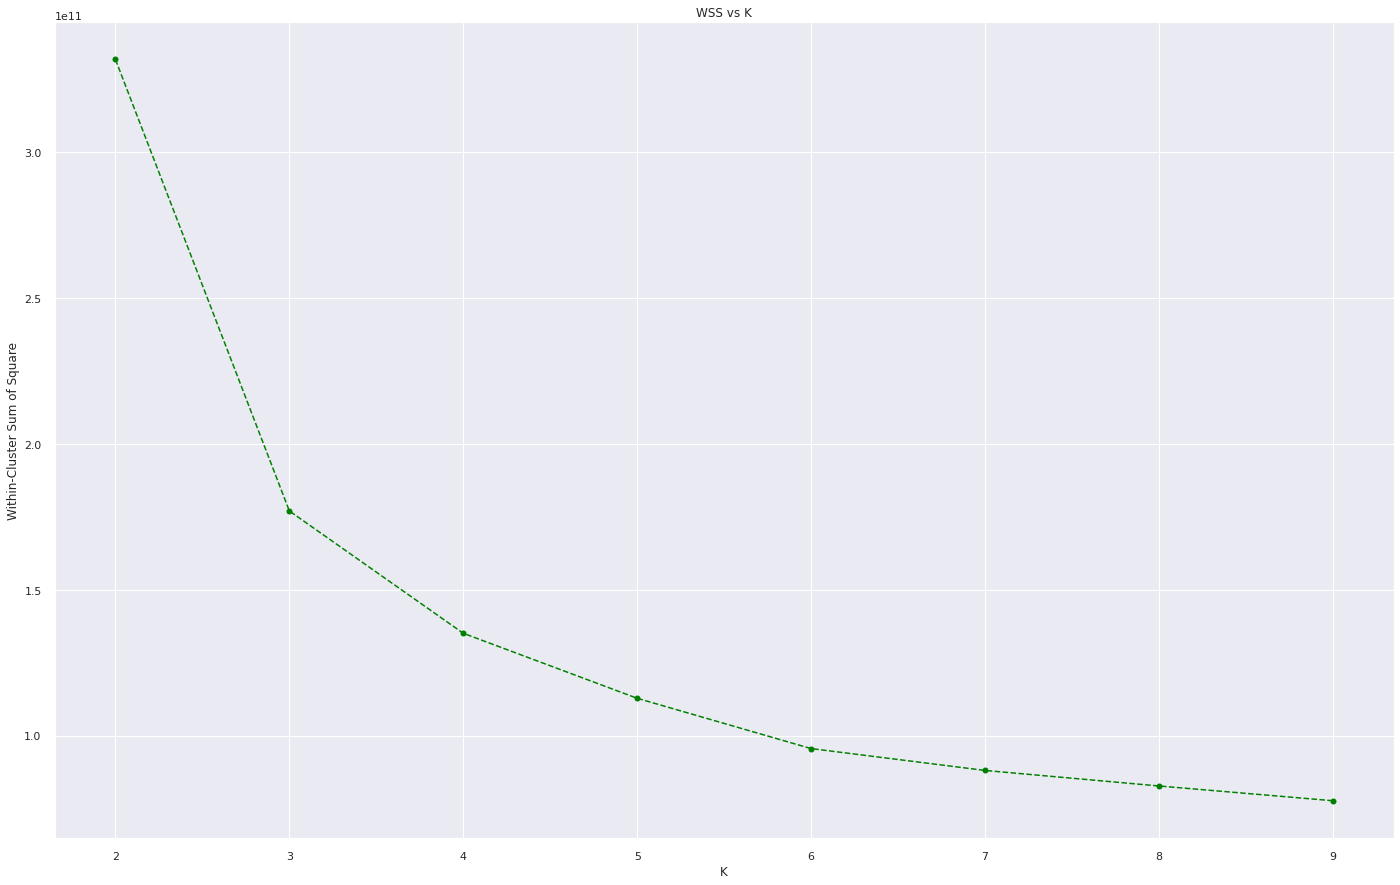

In [183]:
plt.plot(n_clusters, wss, linestyle='--', marker='o', color='green')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('WSS vs K')
plt.show()

Alternatively, it is possible to use the methods within the yellowbrick library

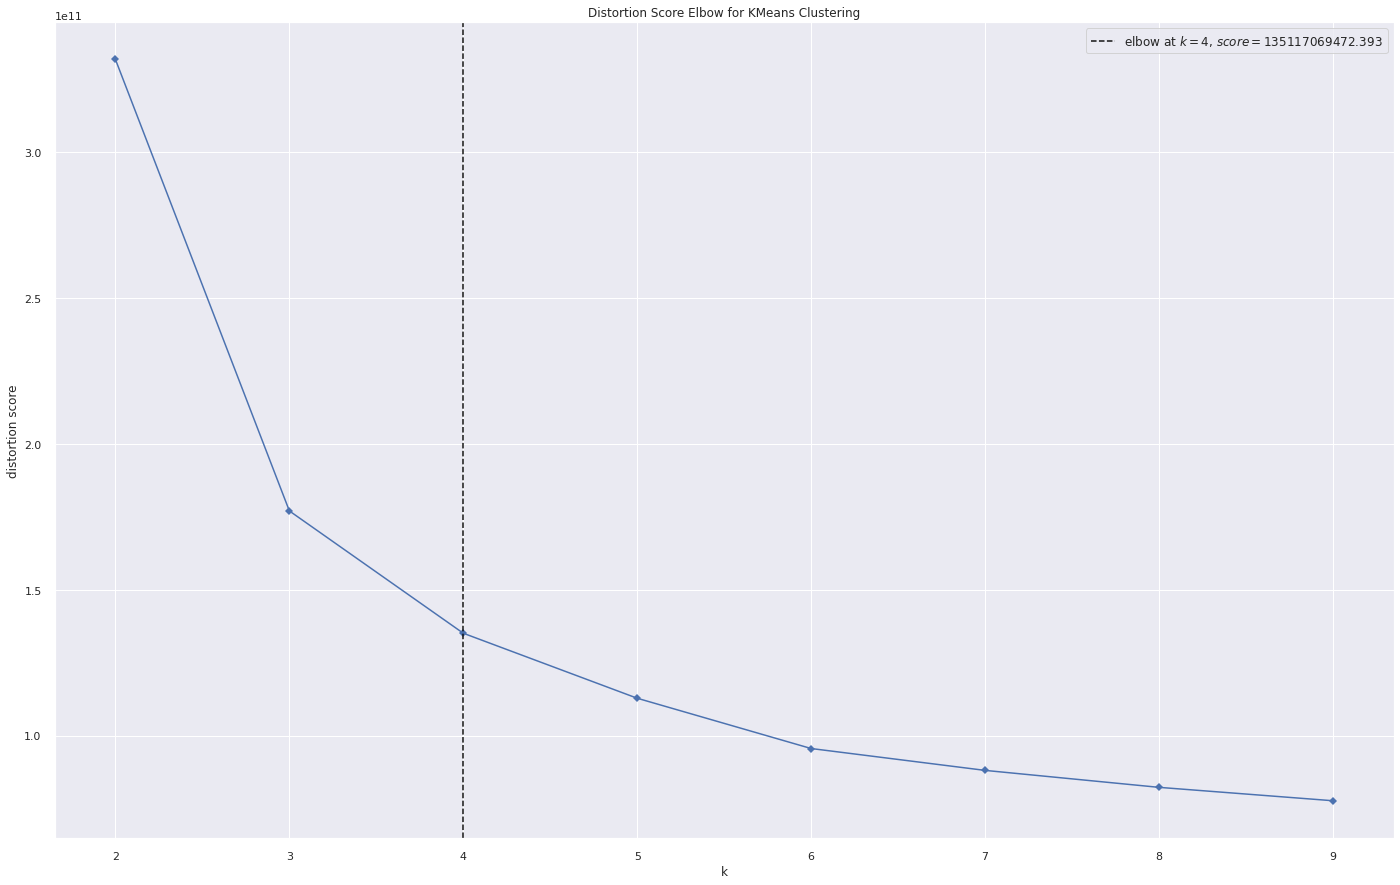

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [184]:
kmeans = KElbowVisualizer(cluster.KMeans(), k=n_clusters, timings=False)
kmeans.fit(X)
kmeans.show()

### 7.1.2. Sillhouette score

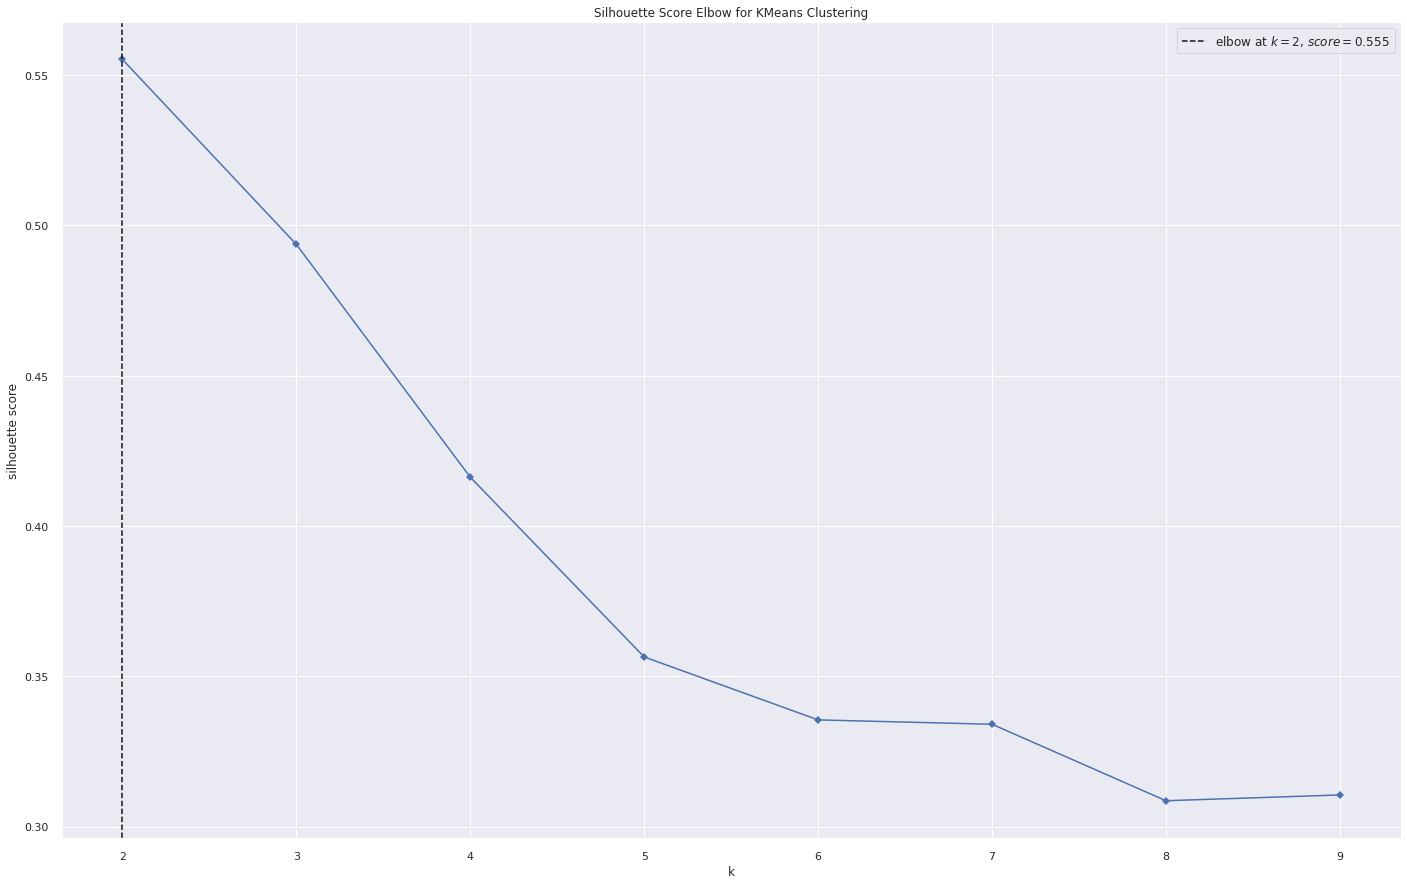

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [185]:
kmeans = KElbowVisualizer(cluster.KMeans(), k=n_clusters, timings=False, metric='silhouette')
kmeans.fit(X)
kmeans.show()

### 7.1.3. Silhouette analysis

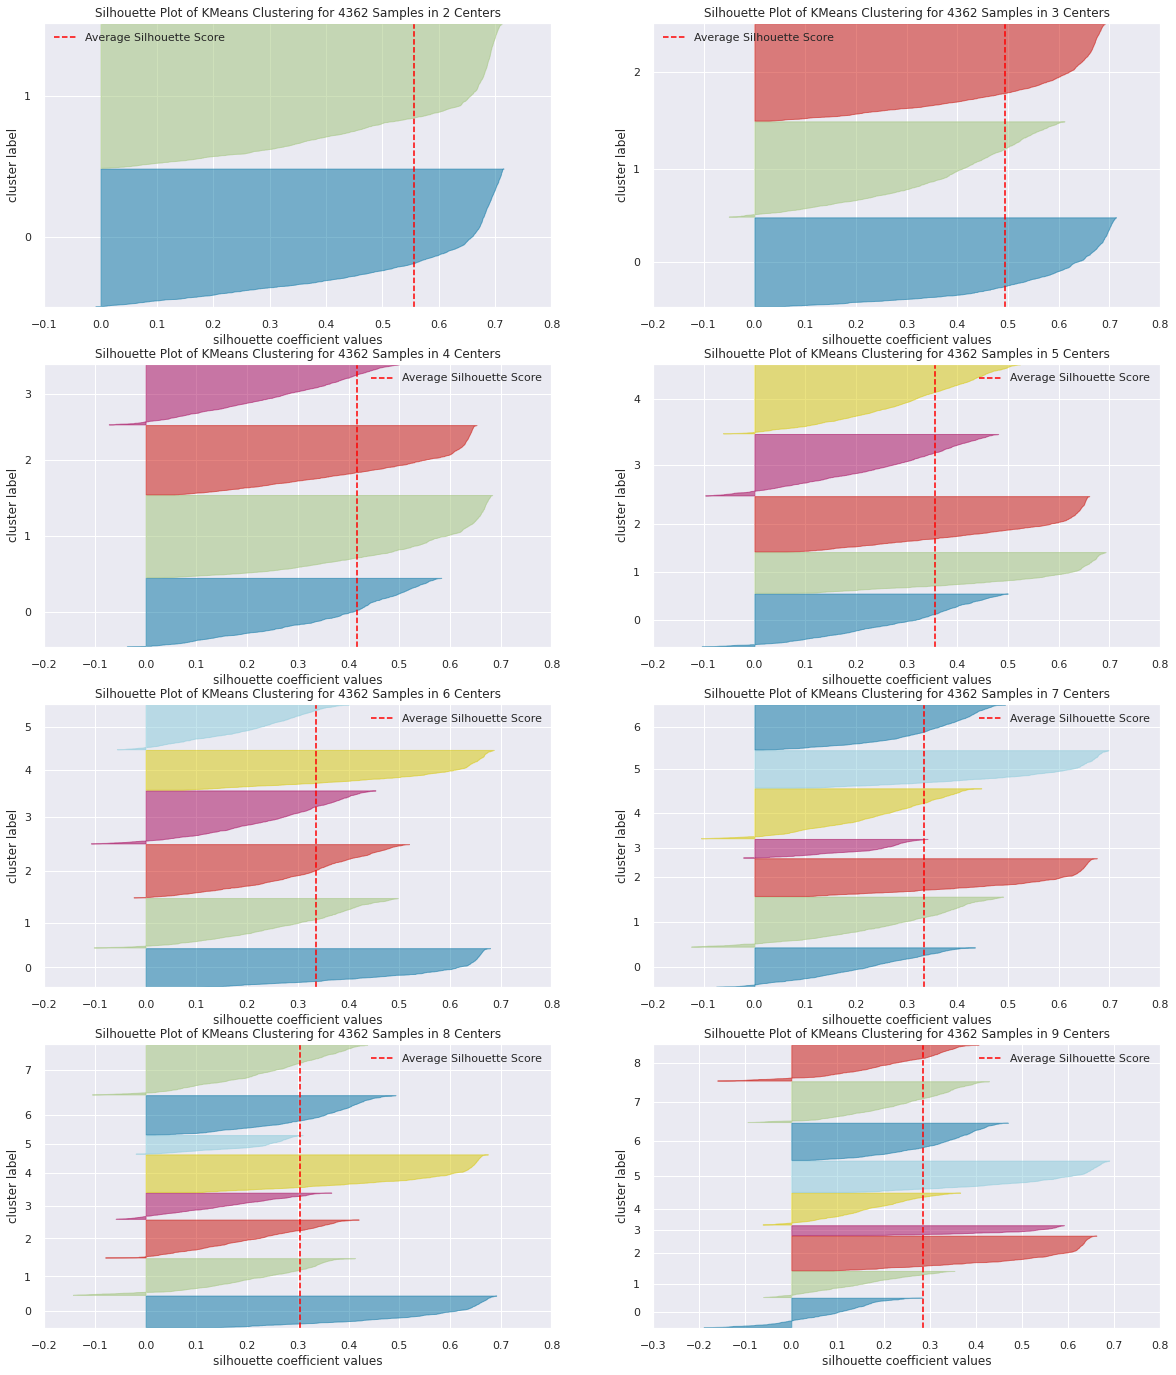

In [186]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
fig, ax = plt.subplots(4, 2, figsize=(20,24))

for k in n_clusters:
    km = cluster.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100,random_state=42)
    
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize()

# 8. Model training

## 8.1. K-Means model

In [187]:
k = 4

kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42)
kmeans.fit(X)
print('WSS Value for original data: {}'.format(kmeans.inertia_))

labels = kmeans.labels_

WSS Value for original data: 135117221251.6141


## 8.2. Cluster validation

### WSS

In [188]:
print('WSS Value for original data: {}'.format(kmeans.inertia_))

WSS Value for original data: 135117221251.6141


### Silhouette score

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

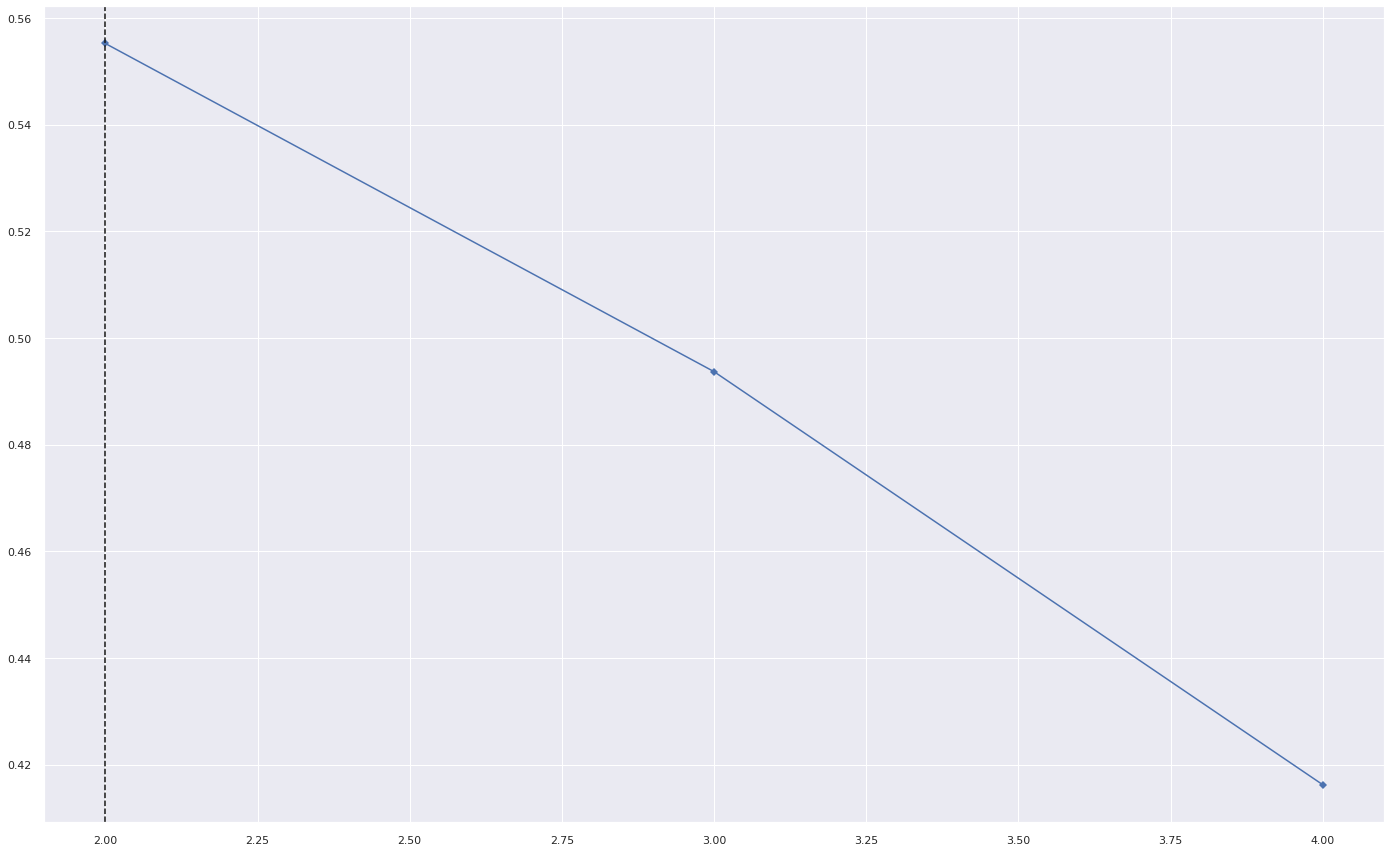

In [189]:
kmeans_silhouette = KElbowVisualizer(kmeans, k=4, timings=False, metric='silhouette')
kmeans_silhouette.fit(X)


# 9. Cluster analysis

In [190]:
df_ref = df_ref[df_ref['customer_id'].isin(df4[['customer_id']])]
df9 = df_ref.copy()
df9['cluster'] = labels

## 9.1. Visualization Inspection

In [191]:
#fig = px.scatter_3d(df9, x='recency_p', y='freq_p', z='purchases', color='cluster')
#fig.show()

#fig = px.scatter_3d(df9, x='recency_d', y='freq_d', z='devolutions', color='cluster')
#fig.show()

### 9.1.3. Pair visualization

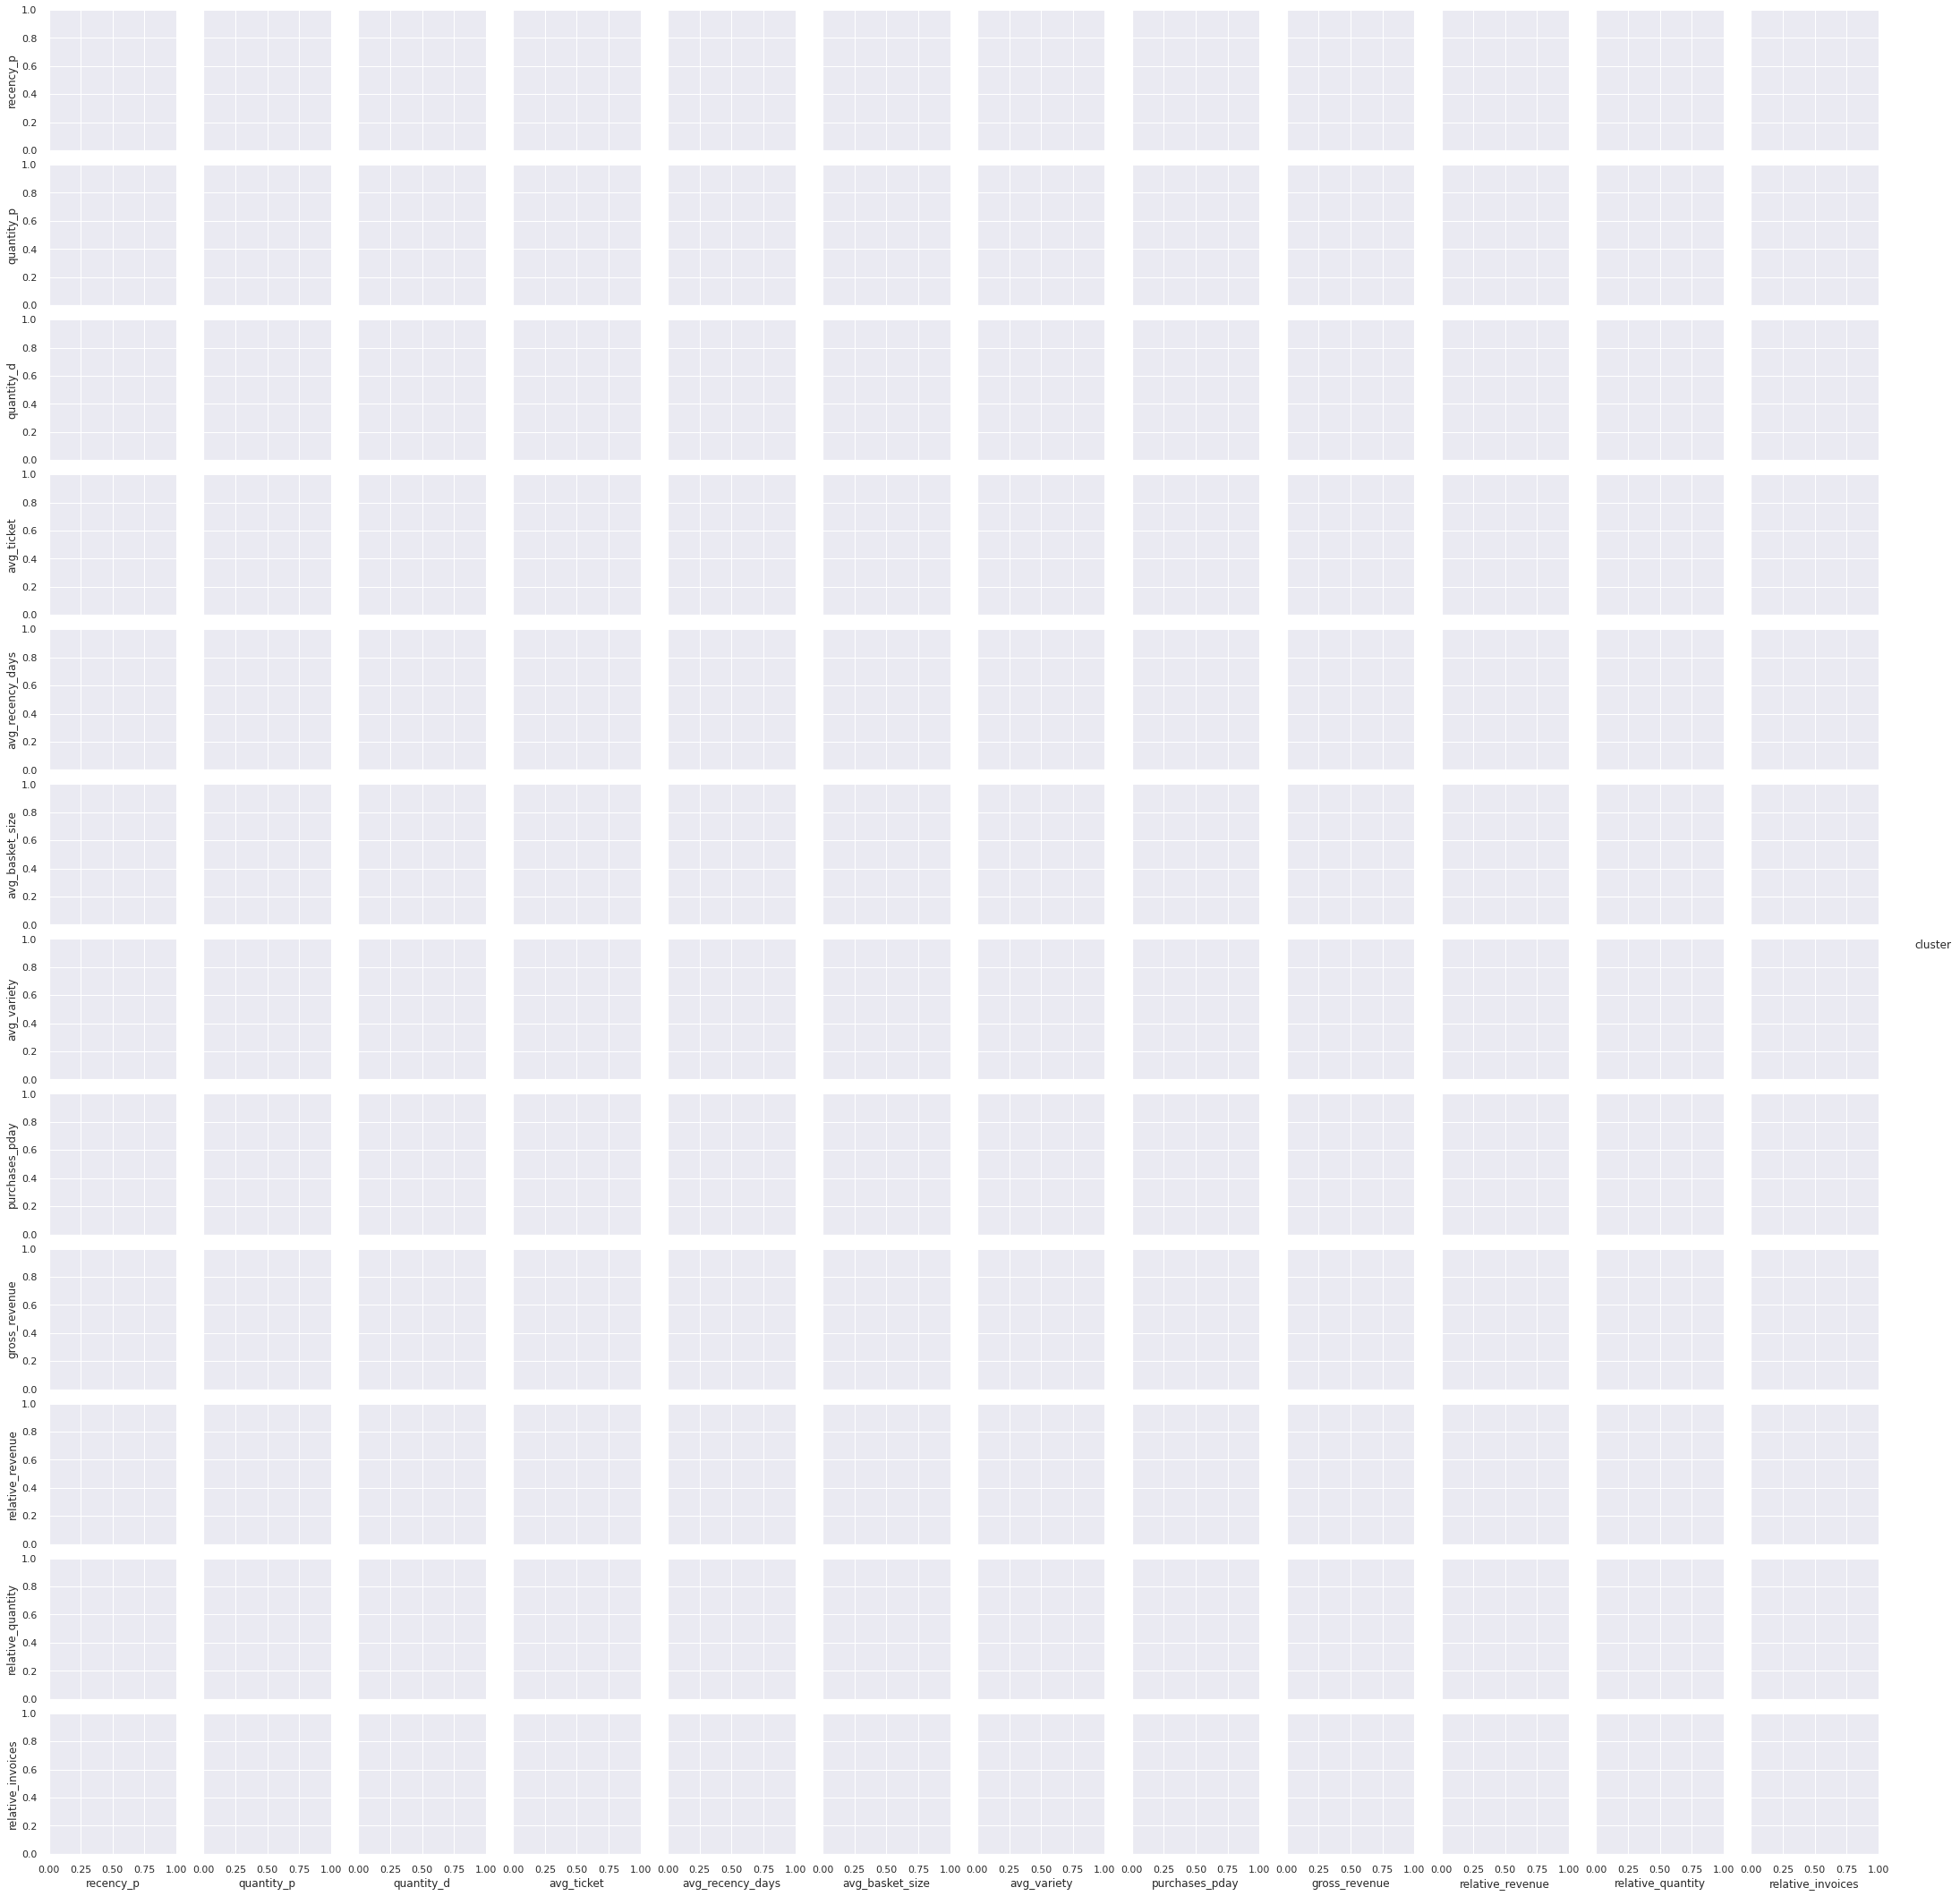

In [192]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

plt.show()

### 9.1.4. UMAP - t-SNE

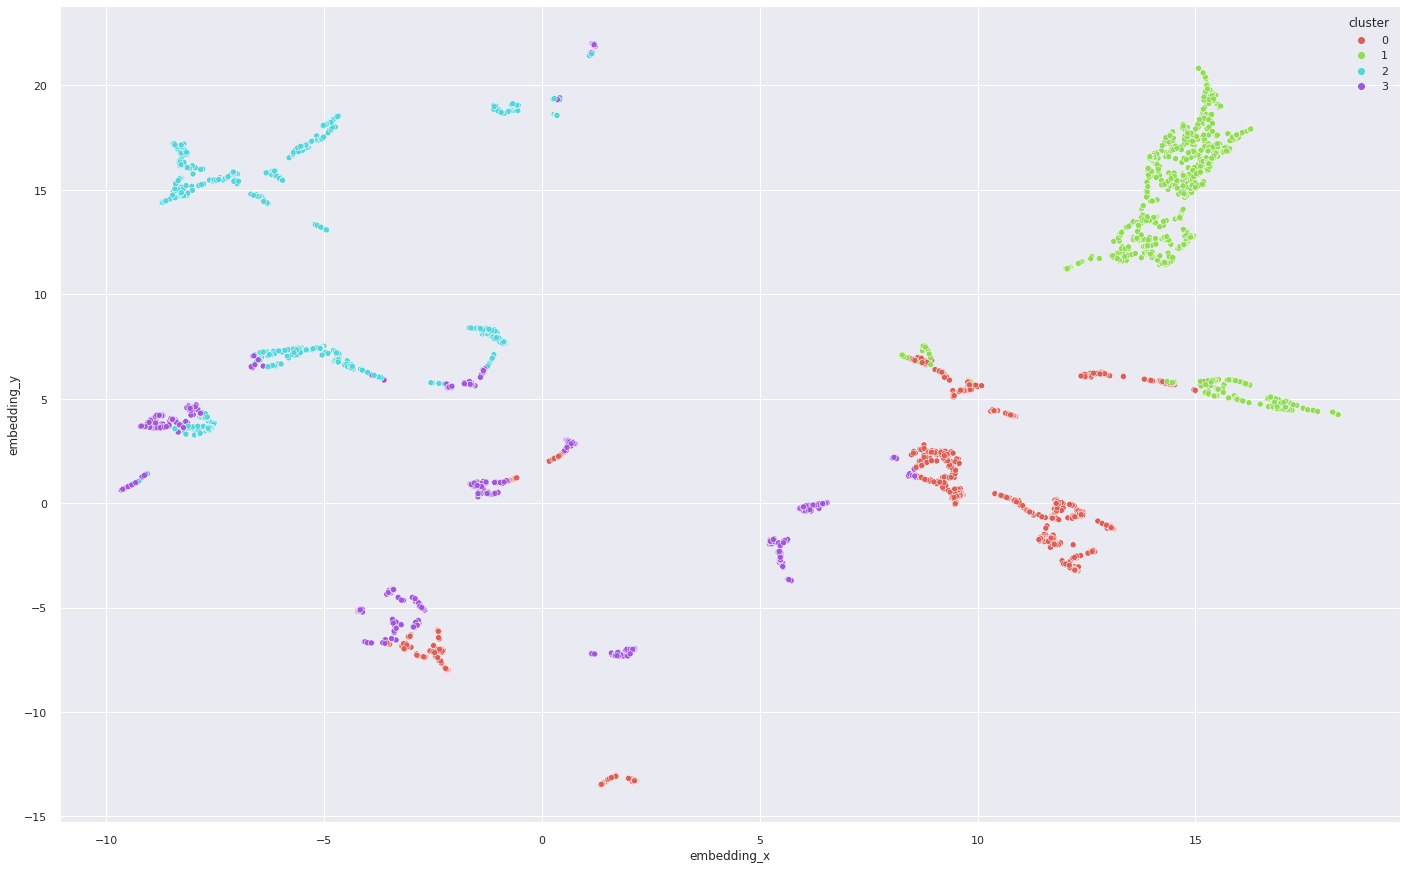

In [193]:
df_viz1 = df9.drop(columns=['customer_id'], axis=1)

reducer = ump.UMAP(n_neighbors=25, random_state=42)
embedding = reducer.fit_transform(X)

df_viz1['embedding_x'] = embedding[:,0]
df_viz1['embedding_y'] = embedding[:,1]

sns.scatterplot(x='embedding_x',y='embedding_y', hue='cluster', palette=sns.color_palette('hls',n_colors=len(df_viz1['cluster'].unique())), data=df_viz1)
plt.show()

## 9.2. Cluster profile

The profile of each cluster can be represented as a persona, and the persona is the mean or median behavior of all other customers inside the cluster

In [169]:
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = round(100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum()), 3)

#df_avg_purchases = round(df9[['purchases', 'cluster']].groupby('cluster').mean().reset_index(), 2)
#df_avg_devolutions = round(df9[['devolutions', 'cluster']].groupby('cluster').mean().reset_index(), 2)
#df_avg_relation = round(df9[['purc_dev','cluster']].groupby('cluster').mean().reset_index() , 2)

df_avg_recency_p = round(df9[['cluster', 'recency_p']].groupby('cluster').mean().reset_index(), 2)
#df_avg_recency_d = round(df9[['cluster', 'recency_d']].groupby('cluster').mean().reset_index(), 2)

#df_avg_frequency_p = round(df9[['cluster','quantity_p']].groupby('cluster').mean().reset_index(), 2)
#df_avg_frequency_d = round(df9[['cluster','quantity_d']].groupby('cluster').mean().reset_index(), 2)

df_avg_ticket = round(df9[['cluster','avg_ticket']].groupby('cluster').mean().reset_index(), 2)
df_avg_recency_days = round(df9[['cluster','avg_recency_days']].groupby('cluster').mean().reset_index(), 2)
#df_purchases_pday = round(df9[['cluster','purchases_pday']].groupby('cluster').mean().reset_index(), 2)

#df_cluster = pd.merge(df_cluster, df_avg_purchases, on='cluster', how='inner')
#df_cluster = pd.merge(df_cluster, df_avg_devolutions, on='cluster', how='inner')
#df_cluster = pd.merge(df_cluster, df_avg_relation, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_recency_p, on='cluster', how='inner')
#df_cluster = pd.merge(df_cluster, df_avg_recency_d, on='cluster', how='inner')
#df_cluster = pd.merge(df_cluster, df_avg_frequency_p, on='cluster', how='inner')
#df_cluster = pd.merge(df_cluster, df_avg_frequency_d, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_ticket, on='cluster', how='inner')
df_cluster = pd.merge(df_cluster, df_avg_recency_days, on='cluster', how='inner')
#df_cluster = pd.merge(df_cluster, df_purchases_pday, on='cluster', how='inner')



df_cluster

,cluster,customer_id,perc_customer,recency_p,avg_ticket,avg_recency_days
0,0,0,NaN,NaN,NaN,NaN
1,1,0,NaN,NaN,NaN,NaN
2,2,0,NaN,NaN,NaN,NaN
3,3,0,NaN,NaN,NaN,NaN


# 10. Deploy to production